In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import xgboost as xgb
import warnings
import string

# data visualization
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

# Algorithms
from sklearn import linear_model
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, auc,confusion_matrix, f1_score, roc_curve , roc_auc_score

SEED = 42

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


### **Getting the Data Overview**

* `PassengerId` is the unique id of the row and it doesn't have any effect on target
* `Survived` is the target variable we are trying to predict (**0** or **1**):
    - **1 = Survived**
    - **0 = Not Survived**
* `Pclass` (Passenger Class) is the socio-economic status of the passenger and it is a categorical ordinal feature which has **3** unique values (**1**,  **2 **or **3**):
    - **1 = Upper Class**
    - **2 = Middle Class**
    - **3 = Lower Class**
* `Name`, `Sex` and `Age` are self-explanatory
* `SibSp` is the total number of the passengers' siblings and spouse
* `Parch` is the total number of the passengers' parents and children
* `Ticket` is the ticket number of the passenger
* `Fare` is the passenger fare
* `Cabin` is the cabin number of the passenger
* `Embarked` is port of embarkation and it is a categorical feature which has **3** unique values (**C**, **Q** or **S**):
    - **C = Cherbourg**
    - **Q = Queenstown**
    - **S = Southampton**

In [2]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

## **1. Exploratory Data Analysis**

In [3]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


From the above plots, it can be seen that the training and test datasets, “age” and “cabin" features have missing values.

* Training set has **891** rows and test set has **418** rows
* Training set have **12** features and test set have **11** features
* One extra feature in training set is `Survived` feature, which is the target variable

In [6]:
def concat_data(train_data, test_data):
    # Returns a concatenated df of training and test set
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

def divide_data(all_data):
    # Returns divided dfs of training and test set
    return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)

dt_all = concat_data(train_data, test_data)

train_data.name = 'Training dataset'
test_data.name = 'Test dataset'
dt_all.name = 'Titanic_Disaster dataset' 

dts = [train_data, test_data]

print('Number of Training Examples = {}'.format(train_data.shape[0]))
print('Number of Test Examples = {}\n'.format(test_data.shape[0]))
print('Training X Shape = {}'.format(train_data.shape))
print('Training y Shape = {}\n'.format(train_data['Survived'].shape[0]))
print('Test X Shape = {}'.format(test_data.shape))
print('Test y Shape = {}\n'.format(test_data.shape[0]))
print(train_data.columns)
print(test_data.columns)

Number of Training Examples = 891
Number of Test Examples = 418

Training X Shape = (891, 12)
Training y Shape = 891

Test X Shape = (418, 11)
Test y Shape = 418

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


### **1.1 Does the dataset contain missing values?**
As seen from below, some columns have missing values. `display_missing` function shows the count of missing values in every column in both training and test set.
* Training set have missing values in `Age`, `Cabin` and `Embarked` columns
* Test set have missing values in `Age`, `Cabin` and `Fare` columns

It is convenient to work on concatenated training and test set while dealing with missing values, otherwise filled data may overfit to training or test set samples. The count of missing values in `Age`, `Embarked` and `Fare` are smaller compared to total sample, but roughly **80%** of the `Cabin` is missing. Missing values in `Age`, `Embarked` and `Fare` can be filled with descriptive statistical measures but that wouldn't work for `Cabin`.

In [7]:
def display_missing(dt):    
    for col in dt.columns.tolist():          
        print('{} column missing values: {}'.format(col, dt[col].isnull().sum()))
    print('\n')
    
for dt in dts:
    print('{}'.format(dt.name))
    display_missing(dt)

Training dataset
PassengerId column missing values: 0
Survived column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 177
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 0
Cabin column missing values: 687
Embarked column missing values: 2


Test dataset
PassengerId column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 86
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 1
Cabin column missing values: 327
Embarked column missing values: 0




#### **1.1.1 Age**
Missing values in `Age` are filled with median age, but using median age of the whole data set is not a good choice. Median age of `Pclass` groups is the best choice because of its high correlation with `Age` **(0.408106)** and `Survived` **(0.338481)**. It is also more logical to group ages by passenger classes instead of other features.

In [8]:
dt_all_corr = dt_all.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
dt_all_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
dt_all_corr[dt_all_corr['Feature 1'] == 'Age']

,Feature 1,Feature 2,Correlation Coefficient
0,Age,Age,1.000000
9,Age,Pclass,0.408106
18,Age,SibSp,0.243699
21,Age,Fare,0.178740
26,Age,Parch,0.150917
30,Age,Survived,0.077221
41,Age,PassengerId,0.028814


In order to be more accurate, `Sex` feature is used as the second level of `groupby` while filling the missing `Age` values. As seen from below, `Pclass` and `Sex` groups have distinct median `Age` values. When passenger class increases, the median age for both males and females also increases. However, females tend to have slightly lower median `Age` than males. The median ages below are used for filling the missing values in `Age` feature.

In [9]:
age_by_pclass_sex = dt_all.groupby(['Sex', 'Pclass']).median()['Age']

for pclass in range(1, 4):
    for sex in ['female', 'male']:
        print('Median age of Pclass {} {}s: {}'.format(pclass, sex, age_by_pclass_sex[sex][pclass]))
print('Median age of all passengers: {}'.format(dt_all['Age'].median()))

# Filling the missing values in Age with the medians of Sex and Pclass groups
dt_all['Age'] = dt_all.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

Median age of Pclass 1 females: 36.0
Median age of Pclass 1 males: 42.0
Median age of Pclass 2 females: 28.0
Median age of Pclass 2 males: 29.5
Median age of Pclass 3 females: 22.0
Median age of Pclass 3 males: 25.0
Median age of all passengers: 28.0


#### **1.1.2 Embarked**
`Embarked` is a categorical feature and there are only **2** missing values in whole data set. Both of those passengers are female, upper class and they have the same ticket number. This means that they know each other and embarked from the same port together. The mode `Embarked` value for an upper class female passenger is **C (Cherbourg)**, but this doesn't necessarily mean that they embarked from that port.

In [10]:
dt_all[dt_all['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572


In [11]:
# Filling the missing values in Embarked with S which is the common value
#common_value = 'S'
#data = [train_data, test_data]
#for dataset in data:
#    dataset['Embarked'] = dataset['Embarked'].fillna(common_value)

In [12]:
# Filling the missing values in Embarked with S which is the common value
common_value = 'S'
dt_all['Embarked'] = dt_all['Embarked'].fillna(common_value)

#### **1.1.3 Fare**
There is only one passenger with missing `Fare` value. We can assume that `Fare` is related to family size (`Parch` and `SibSp`) and `Pclass` features. Median `Fare` value of a male with a third class ticket and no family is a logical choice to fill the missing value.

In [13]:
dt_all[dt_all['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


In [14]:
median_fare = dt_all.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
# Filling the missing value in Fare with the median Fare of 3rd class alone passenger
dt_all['Fare'] = dt_all['Fare'].fillna(median_fare)

#### **1.2.4 Cabin**
`Cabin` feature is little bit tricky and it needs further exploration. The large portion of the `Cabin` feature is missing and the feature itself can't be ignored completely because some the cabins might have higher survival rates. It turns out to be the first letter of the `Cabin` values are the decks in which the cabins are located. Those decks were mainly separated for one passenger class, but some of them were used by multiple passenger classes.
![alt text](https://upload.wikimedia.org/wikipedia/commons/5/5d/Titanic_side_plan_annotated_English.png)
* On the Boat Deck there were **6** rooms labeled as **T, U, W, X, Y, Z** but only the **T** cabin is present in the dataset
* **A**, **B** and **C** decks were only for 1st class passengers
* **D** and **E** decks were for all classes
* **F** and **G** decks were for both 2nd and 3rd class passengers
* From going **A** to **G**, distance to the staircase increases which might be a factor of survival

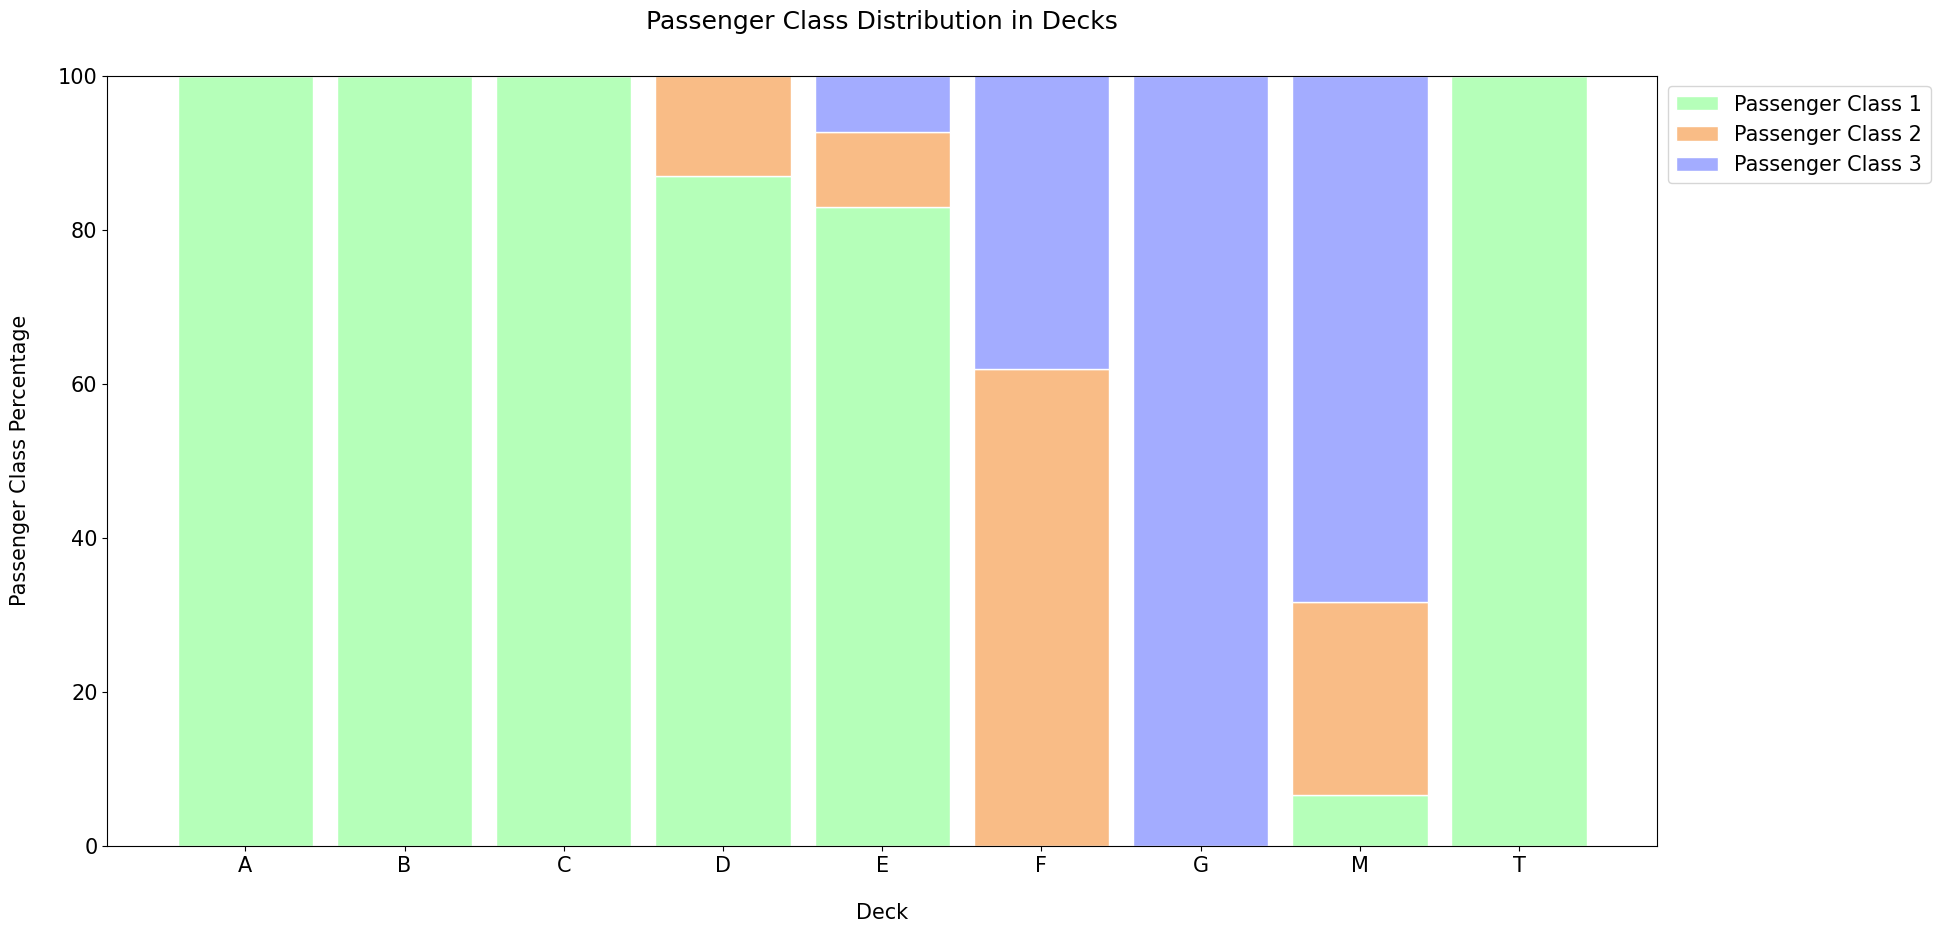

In [15]:
# Creating Deck column from the first letter of the Cabin column (M stands for Missing)
dt_all['Deck'] = dt_all['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

dt_all_decks = dt_all.groupby(['Deck', 'Pclass']).count().drop(columns=['Survived', 'Sex', 'Age', 'SibSp', 'Parch', 
                                                                        'Fare', 'Embarked', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name': 'Count'}).transpose()

def get_pclass_dist(dt):
    
    # Creating a dictionary for every passenger class count in every deck
    deck_counts = {'A': {}, 'B': {}, 'C': {}, 'D': {}, 'E': {}, 'F': {}, 'G': {}, 'M': {}, 'T': {}}
    decks = dt.columns.levels[0]    
    
    for deck in decks:
        for pclass in range(1, 4):
            try:
                count = dt[deck][pclass][0]
                deck_counts[deck][pclass] = count 
            except KeyError:
                deck_counts[deck][pclass] = 0
                
    dt_decks = pd.DataFrame(deck_counts)    
    deck_percentages = {}

    # Creating a dictionary for every passenger class percentage in every deck
    for col in dt_decks.columns:
        deck_percentages[col] = [(count / dt_decks[col].sum()) * 100 for count in dt_decks[col]]
        
    return deck_counts, deck_percentages

def display_pclass_dist(percentages):
    
    dt_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M', 'T')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85
    
    pclass1 = dt_percentages[0]
    pclass2 = dt_percentages[1]
    pclass3 = dt_percentages[2]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, pclass1, color='#b5ffb9', edgecolor='white', width=bar_width, label='Passenger Class 1')
    plt.bar(bar_count, pclass2, bottom=pclass1, color='#f9bc86', edgecolor='white', width=bar_width, label='Passenger Class 2')
    plt.bar(bar_count, pclass3, bottom=pclass1 + pclass2, color='#a3acff', edgecolor='white', width=bar_width, label='Passenger Class 3')

    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Passenger Class Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Passenger Class Distribution in Decks', size=18, y=1.05)   
    
    plt.show()    

all_deck_count, all_deck_per = get_pclass_dist(dt_all_decks)
display_pclass_dist(all_deck_per)

* **100%** of **A**, **B** and **C** decks are 1st class passengers
* Deck **D** has **87%** 1st class and **13%** 2nd class passengers
* Deck **E** has **83%** 1st class, **10%** 2nd class and **7%** 3rd class passengers
* Deck **F** has **62%** 2nd class and **38%** 3rd class passengers
* **100%** of **G** deck are 3rd class passengers
* There is one person on the boat deck in **T** cabin and he is a 1st class passenger. **T** cabin passenger has the closest resemblance to **A** deck passengers so he is grouped with **A** deck
* Passengers labeled as **M** are the missing values in `Cabin` feature. I don't think it is possible to find those passengers' real `Deck` so I decided to use **M** like a deck

In [16]:
# Passenger in the T deck is changed to A
idx = dt_all[dt_all['Deck'] == 'T'].index
dt_all.loc[idx, 'Deck'] = 'A'

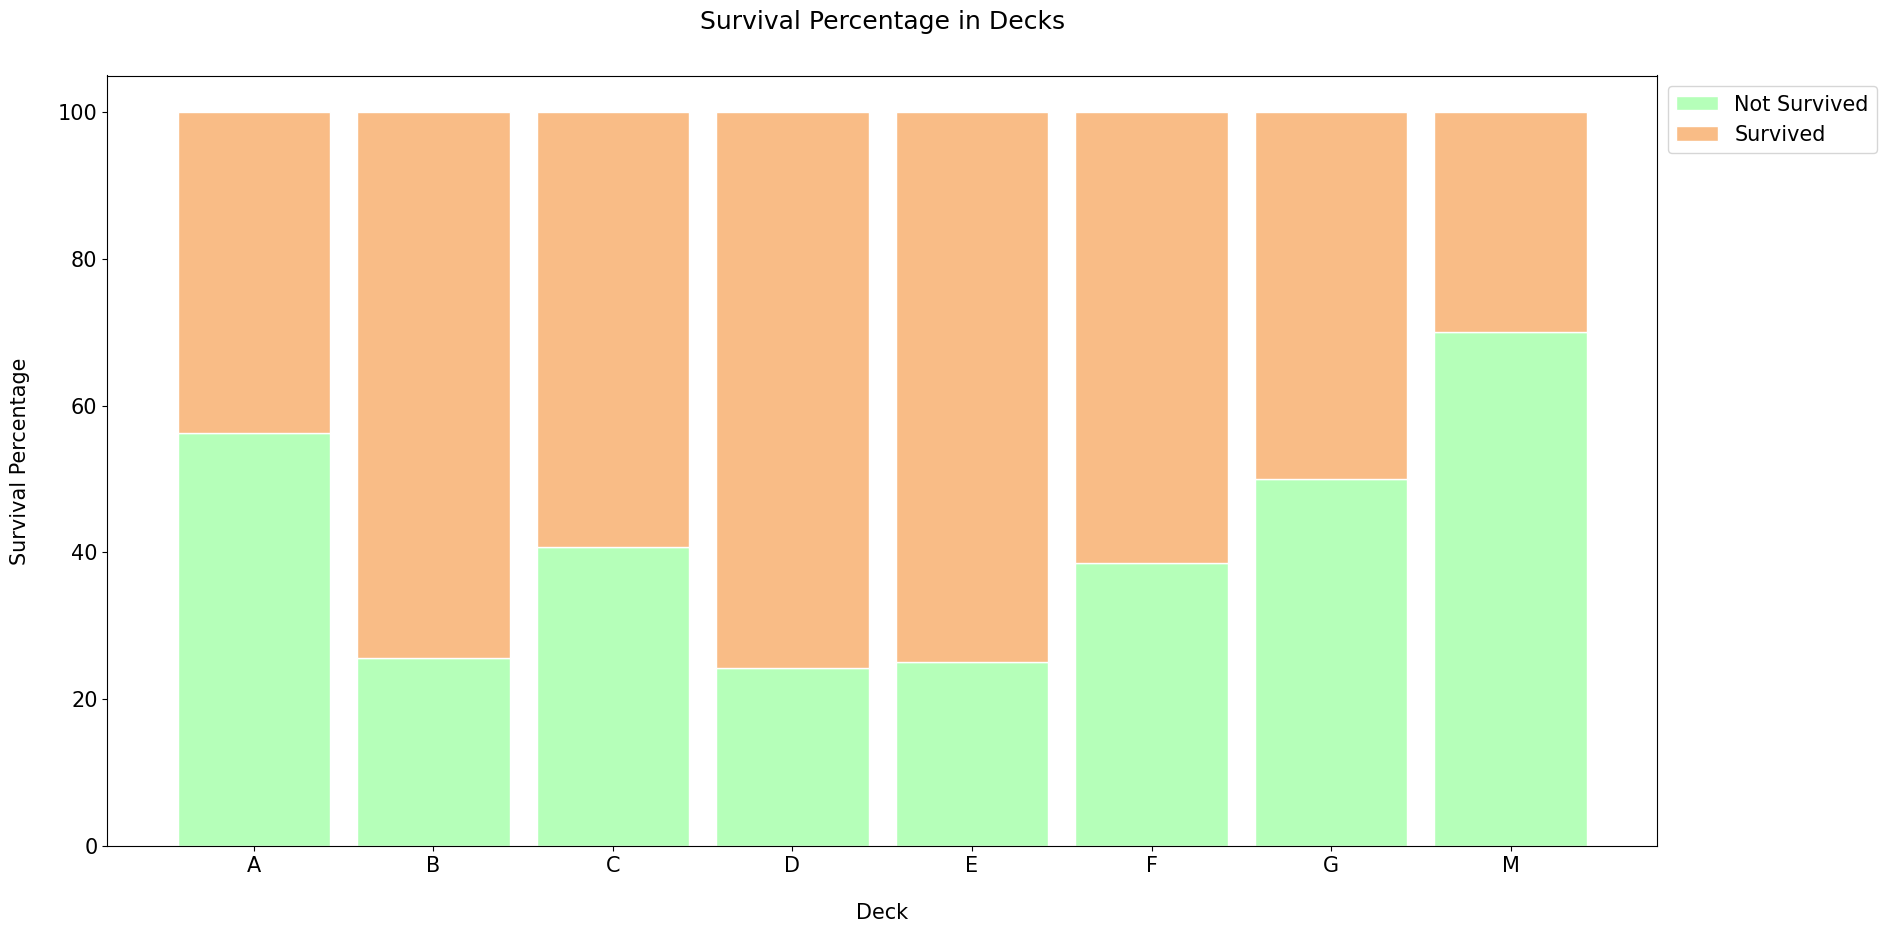

In [17]:
dt_all_decks_survival = dt_all.groupby(['Deck', 'Survived']).count().drop(columns=['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 
                                                                                   'Embarked', 'Pclass', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name':'Count'}).transpose()

def get_survived_dist(dt):
    
    # Creating a dictionary for every survival count in every deck
    surv_counts = {'A':{}, 'B':{}, 'C':{}, 'D':{}, 'E':{}, 'F':{}, 'G':{}, 'M':{}}
    decks = dt.columns.levels[0]    

    for deck in decks:
        for survive in range(0, 2):
            surv_counts[deck][survive] = dt[deck][survive][0]
            
    dt_surv = pd.DataFrame(surv_counts)
    surv_percentages = {}

    for col in dt_surv.columns:
        surv_percentages[col] = [(count / dt_surv[col].sum()) * 100 for count in dt_surv[col]]
        
    return surv_counts, surv_percentages

def display_surv_dist(percentages):
    
    dt_survived_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85    

    not_survived = dt_survived_percentages[0]
    survived = dt_survived_percentages[1]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, not_survived, color='#b5ffb9', edgecolor='white', width=bar_width, label="Not Survived")
    plt.bar(bar_count, survived, bottom=not_survived, color='#f9bc86', edgecolor='white', width=bar_width, label="Survived")
 
    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Survival Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Survival Percentage in Decks', size=18, y=1.05)
    
    plt.show()

all_surv_count, all_surv_per = get_survived_dist(dt_all_decks_survival)
display_surv_dist(all_surv_per)

Every deck has different survival rate. Deck **B**, **C**, **D** and **E** have the highest survival rates. These decks were mostly occupied by 1st class passengers. **M** has the lowest survival rate which is mostly occupied by 2nd and 3rd class passengers. To conclude, cabins used by 1st class passengers have higher survival rates than cabins used by 2nd and 3rd class passengers. In my opinion **M** (Missing `Cabin` values) has the lowest survival rate because they couldn't retrieve the cabin data of the victims. That's why I believe labeling that group as **M** is a reasonable way to handle the missing data. It is a unique group with shared characteristics. `Deck` feature has high-cardinality right now so some of the values are grouped with each other based on their similarities.
* **A**, **B** and **C** decks are labeled as **ABC** because all of them have only 1st class passengers
* **D** and **E** decks are labeled as **DE** because both of them have similar passenger class distribution and same survival rate
* **F** and **G** decks are labeled as **FG** because of the same reason above
* **M** deck doesn't need to be grouped with other decks because it is very different from others and has the lowest survival rate.

In [18]:
dt_all['Deck'] = dt_all['Deck'].replace(['A', 'B', 'C'], 'ABC')
dt_all['Deck'] = dt_all['Deck'].replace(['D', 'E'], 'DE')
dt_all['Deck'] = dt_all['Deck'].replace(['F', 'G'], 'FG')

dt_all['Deck'].value_counts()

M      1014
ABC     182
DE       87
FG       26
Name: Deck, dtype: int64

After filling the missing values in `Age`, `Embarked`, `Fare` and `Deck` features, there is no missing value left in both training and test set. `Cabin` is dropped because `Deck` feature is used instead of it.

In [19]:
# Dropping the Cabin feature
dt_all.drop(['Cabin'], inplace=True, axis=1)

train_data, test_data = divide_data(dt_all)
dts = [train_data, test_data]

for dt in dts:
    display_missing(dt)

Age column missing values: 0
Embarked column missing values: 0
Fare column missing values: 0
Name column missing values: 0
Parch column missing values: 0
PassengerId column missing values: 0
Pclass column missing values: 0
Sex column missing values: 0
SibSp column missing values: 0
Survived column missing values: 0
Ticket column missing values: 0
Deck column missing values: 0


Age column missing values: 0
Embarked column missing values: 0
Fare column missing values: 0
Name column missing values: 0
Parch column missing values: 0
PassengerId column missing values: 0
Pclass column missing values: 0
Sex column missing values: 0
SibSp column missing values: 0
Ticket column missing values: 0
Deck column missing values: 0




### **1.2 Target Distribution**
* **38.38%** ((342/891)*100) of training set is **Class 1**
* **61.62%** ((549/891)*100) of training set is **Class 0**

In [20]:
survived = train_data['Survived'].value_counts()[1]
not_survived = train_data['Survived'].value_counts()[0]
survived_per = survived / train_data.shape[0] * 100
not_survived_per = not_survived / train_data.shape[0] * 100

print('{} of {} passengers survived and it is the {:.2f}% of the training set.'.format(survived, train_data.shape[0], survived_per))
print('{} of {} passengers didnt survive and it is the {:.2f}% of the training set.'.format(not_survived, train_data.shape[0], not_survived_per))

342 of 891 passengers survived and it is the 38.38% of the training set.
549 of 891 passengers didnt survive and it is the 61.62% of the training set.


### **1.3 Correlations**
Features are highly correlated with each other and dependent to each other. The highest correlation between features is **0.549500** in training set and **0.577147** in test set (between `Fare` and `Pclass`). The other features are also highly correlated. There are **9** correlations in training set and **6** correlations in test set that are higher than **0.1**.

In [21]:
dt_train_corr =  train_data.drop(['PassengerId'], axis=1).corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
dt_train_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
dt_train_corr.drop(dt_train_corr.iloc[1::2].index, inplace=True)
dt_train_corr_nd = dt_train_corr.drop(dt_train_corr[dt_train_corr['Correlation Coefficient'] == 1.0].index)

dt_test_corr = test_data.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
dt_test_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
dt_test_corr.drop(dt_test_corr.iloc[1::2].index, inplace=True)
dt_test_corr_nd = dt_test_corr.drop(dt_test_corr[dt_test_corr['Correlation Coefficient'] == 1.0].index)

In [22]:
# Training set high correlations
corr = dt_train_corr_nd['Correlation Coefficient'] > 0.1
dt_train_corr_nd[corr]

,Feature 1,Feature 2,Correlation Coefficient
6,Fare,Pclass,0.549500
8,Age,Pclass,0.417667
10,Parch,SibSp,0.414838
12,Pclass,Survived,0.338481
14,Fare,Survived,0.257307
16,Age,SibSp,0.249747
18,Parch,Fare,0.216225
20,Parch,Age,0.176733
22,SibSp,Fare,0.159651
24,Age,Fare,0.124061


In [23]:
# Test set high correlations
corr = dt_test_corr_nd['Correlation Coefficient'] > 0.1
dt_test_corr_nd[corr]

,Feature 1,Feature 2,Correlation Coefficient
6,Pclass,Fare,0.577489
8,Age,Pclass,0.526789
10,Age,Fare,0.345347
12,SibSp,Parch,0.306895
14,Parch,Fare,0.230410
16,Fare,SibSp,0.172032


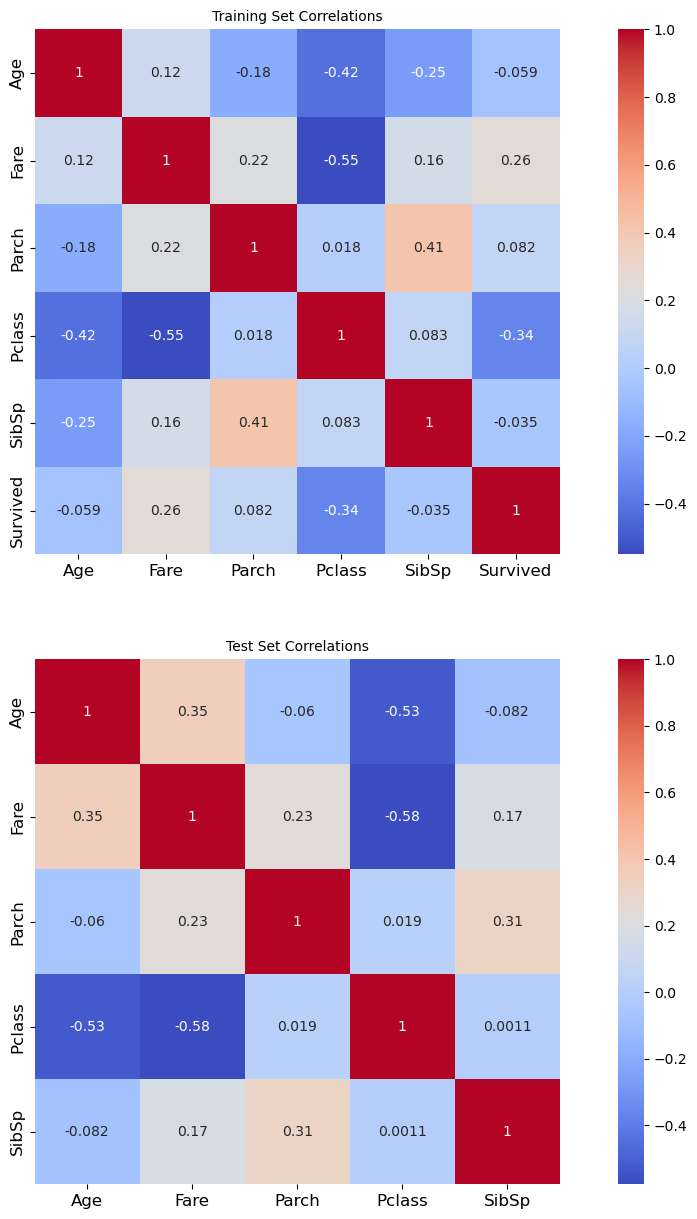

In [24]:
fig, axs = plt.subplots(nrows=2, figsize=(15, 15))

sns.heatmap(train_data.drop(['PassengerId'], axis=1).corr(), ax=axs[0], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 10})
sns.heatmap(test_data.drop(['PassengerId'], axis=1).corr(), ax=axs[1], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 10})

for i in range(2):    
    axs[i].tick_params(axis='x', labelsize=12)
    axs[i].tick_params(axis='y', labelsize=12)
    
axs[0].set_title('Training Set Correlations', size=10)
axs[1].set_title('Test Set Correlations', size=10)

plt.show()

### **1.4 Target Distribution in Features**
#### **1.4.1 Continuous Features**
Both of the continuous features (`Age` and `Fare`) have good split points and spikes for a decision tree to learn. One potential problem for both features is, the distribution has more spikes and bumps in training set, but it is smoother in test set. Model may not be able to generalize to test set because of this reason.

* Distribution of `Age` feature clearly shows that children younger than 15 has a higher survival rate than any of the other age groups
* In distribution of `Fare` feature, the survival rate is higher on distribution tails. The distribution also has positive skew because of the extremely large outliers

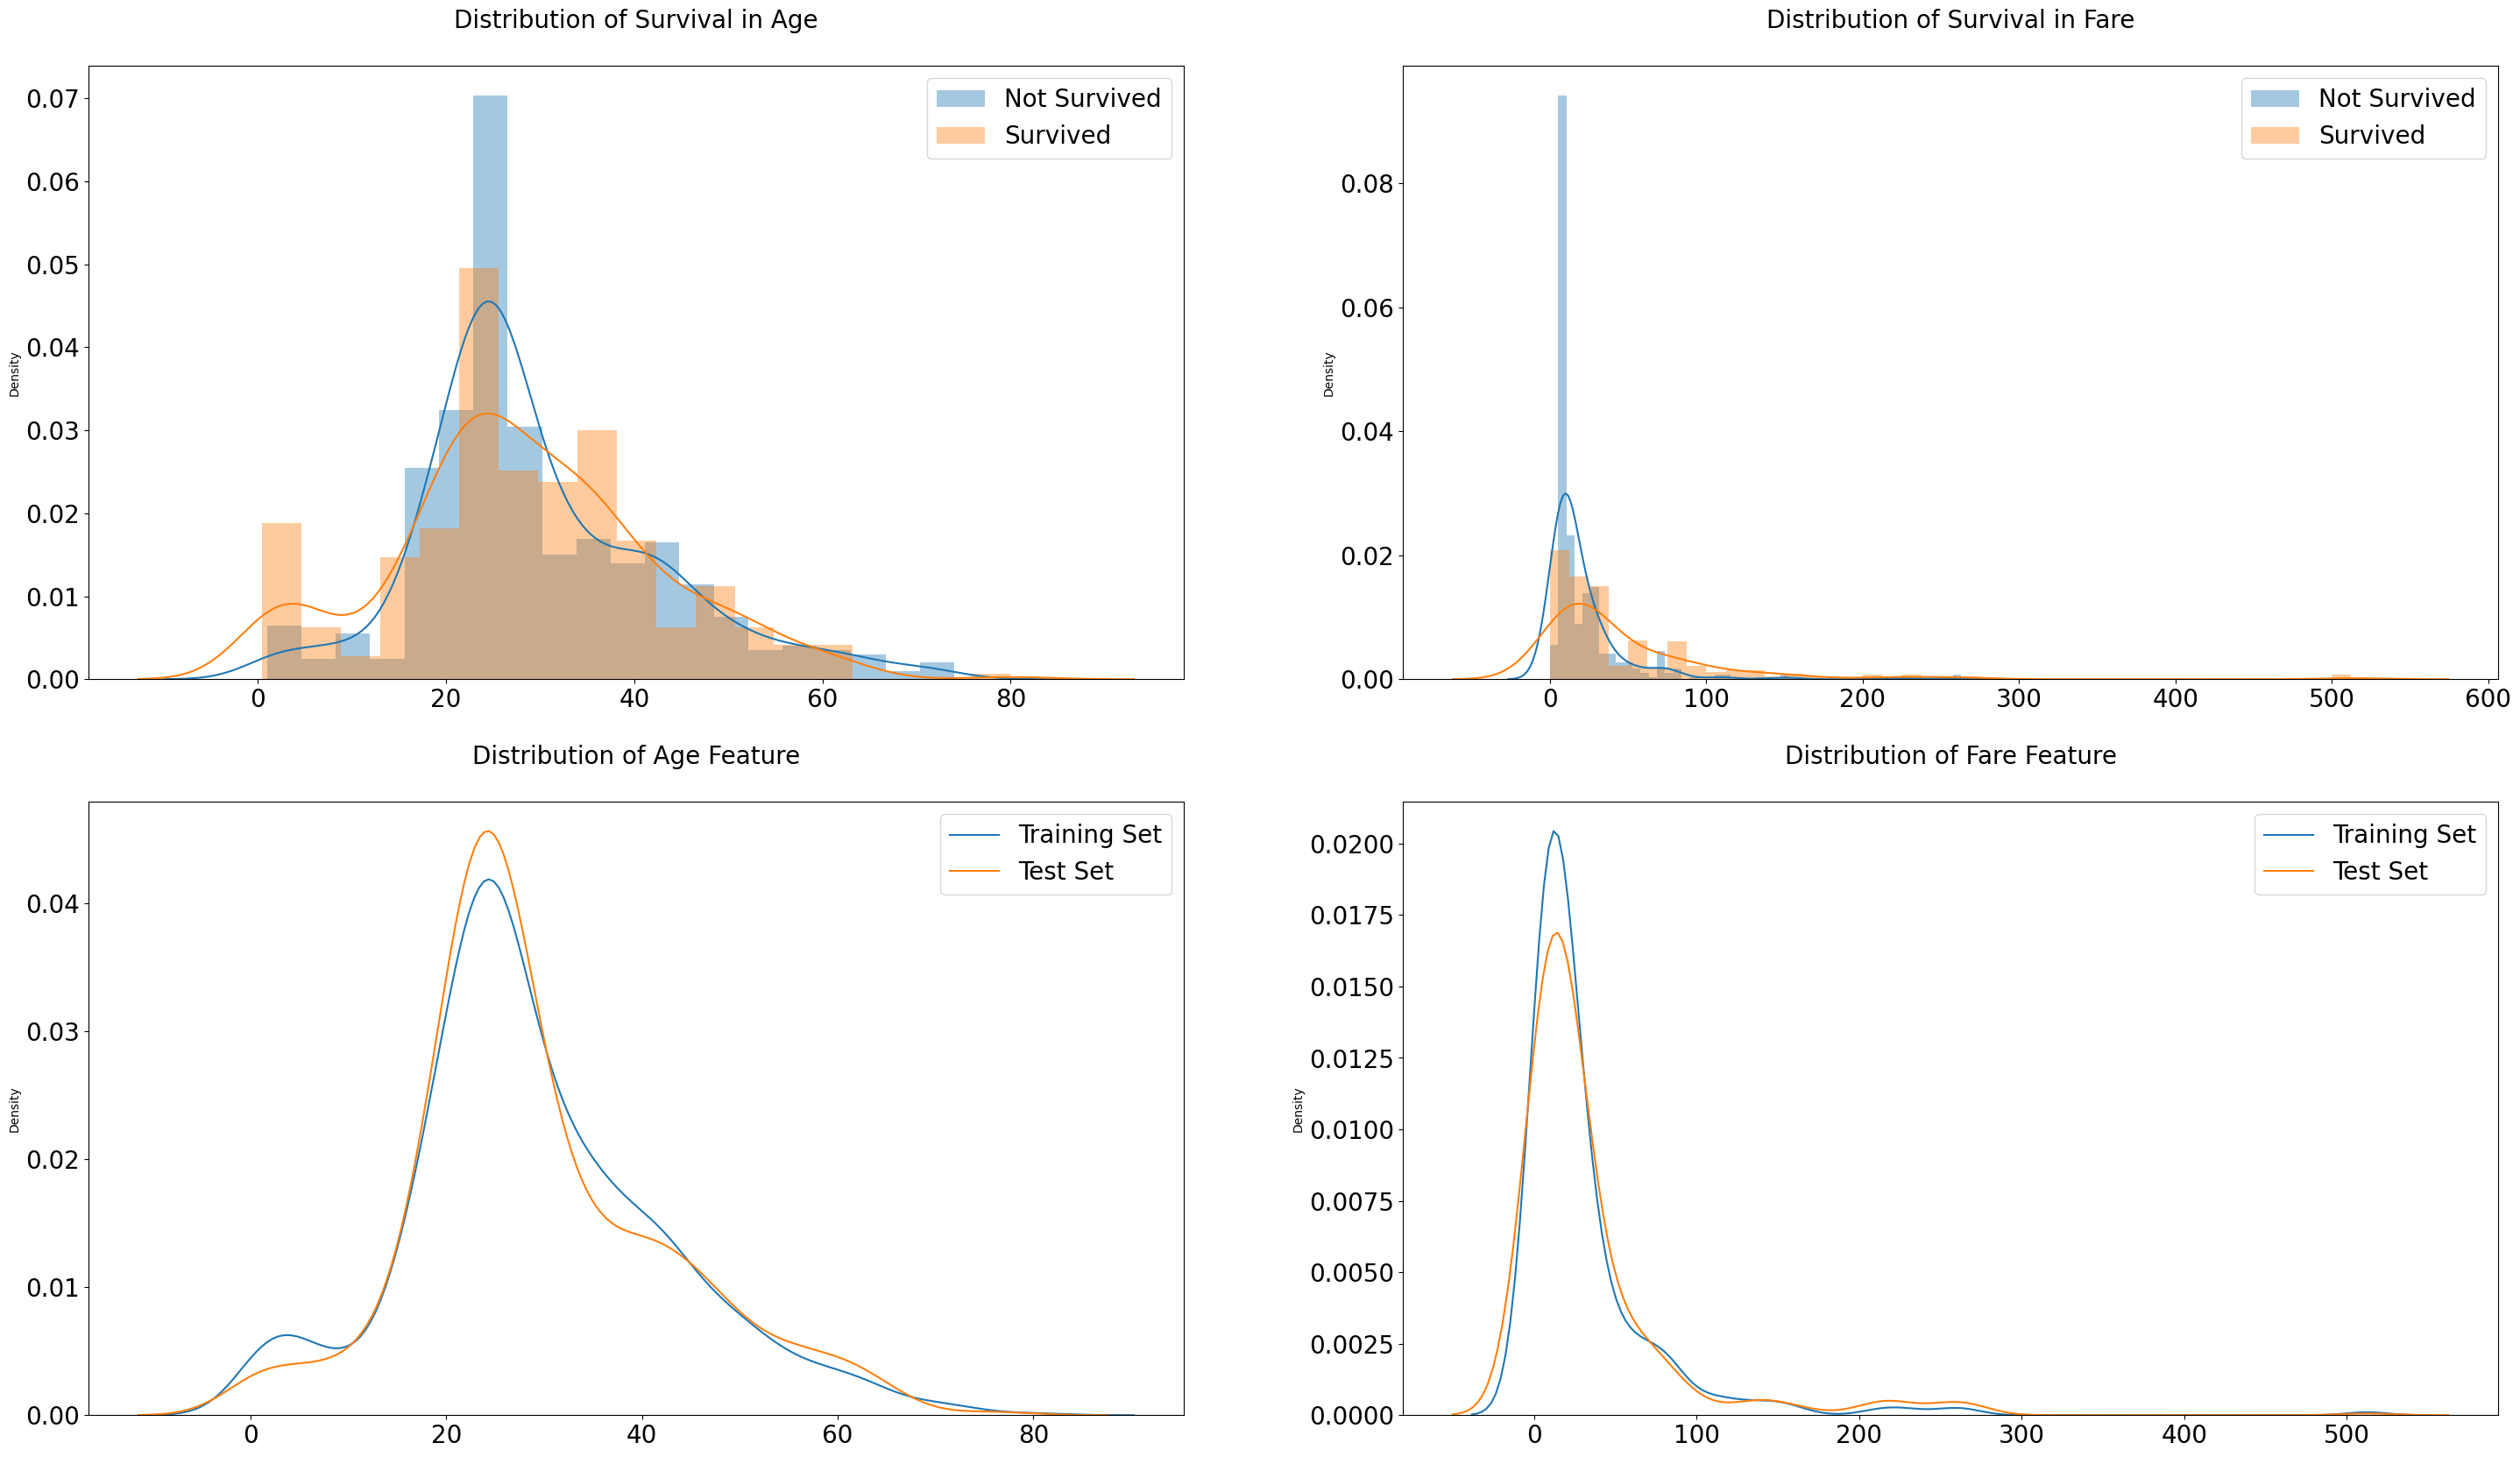

In [25]:
warnings.filterwarnings('ignore')
cont_features = ['Age', 'Fare']
surv = train_data['Survived'] == 1

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20, 20))
plt.subplots_adjust(right=1.5)

for i, feature in enumerate(cont_features):    
    # Distribution of survival in feature
    sns.distplot(train_data[~surv][feature], label='Not Survived', hist=True,  ax=axs[0][i])
    sns.distplot(train_data[surv][feature], label='Survived', hist=True, ax=axs[0][i])
    
    # Distribution of feature in dataset
    sns.distplot(train_data[feature], label='Training Set', hist=False,  ax=axs[1][i])
    sns.distplot(test_data[feature], label='Test Set', hist=False, ax=axs[1][i])
    
    axs[0][i].set_xlabel('')
    axs[1][i].set_xlabel('')
    
    for j in range(2):        
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
    
    axs[0][i].legend(loc='upper right', prop={'size': 20})
    axs[1][i].legend(loc='upper right', prop={'size': 20})
    axs[0][i].set_title('Distribution of Survival in {}'.format(feature), size=20, y=1.05)

axs[1][0].set_title('Distribution of {} Feature'.format('Age'), size=20, y=1.05)
axs[1][1].set_title('Distribution of {} Feature'.format('Fare'), size=20, y=1.05)
        
plt.show()

#### **1.4.2 Categorical Features**
Every categorical feature has at least one class with high mortality rate. Those classes are very helpful to predict whether the passenger is a survivor or victim. Best categorical features are `Pclass` and `Sex` because they have the most homogenous distributions.

* Passengers boarded from **Southampton** has a lower survival rate unlike other ports. More than half of the passengers boarded from **Cherbourg** had survived. This observation could be related to `Pclass` feature
* `Parch` and `SibSp` features show that passengers with only one family member has a higher survival rate

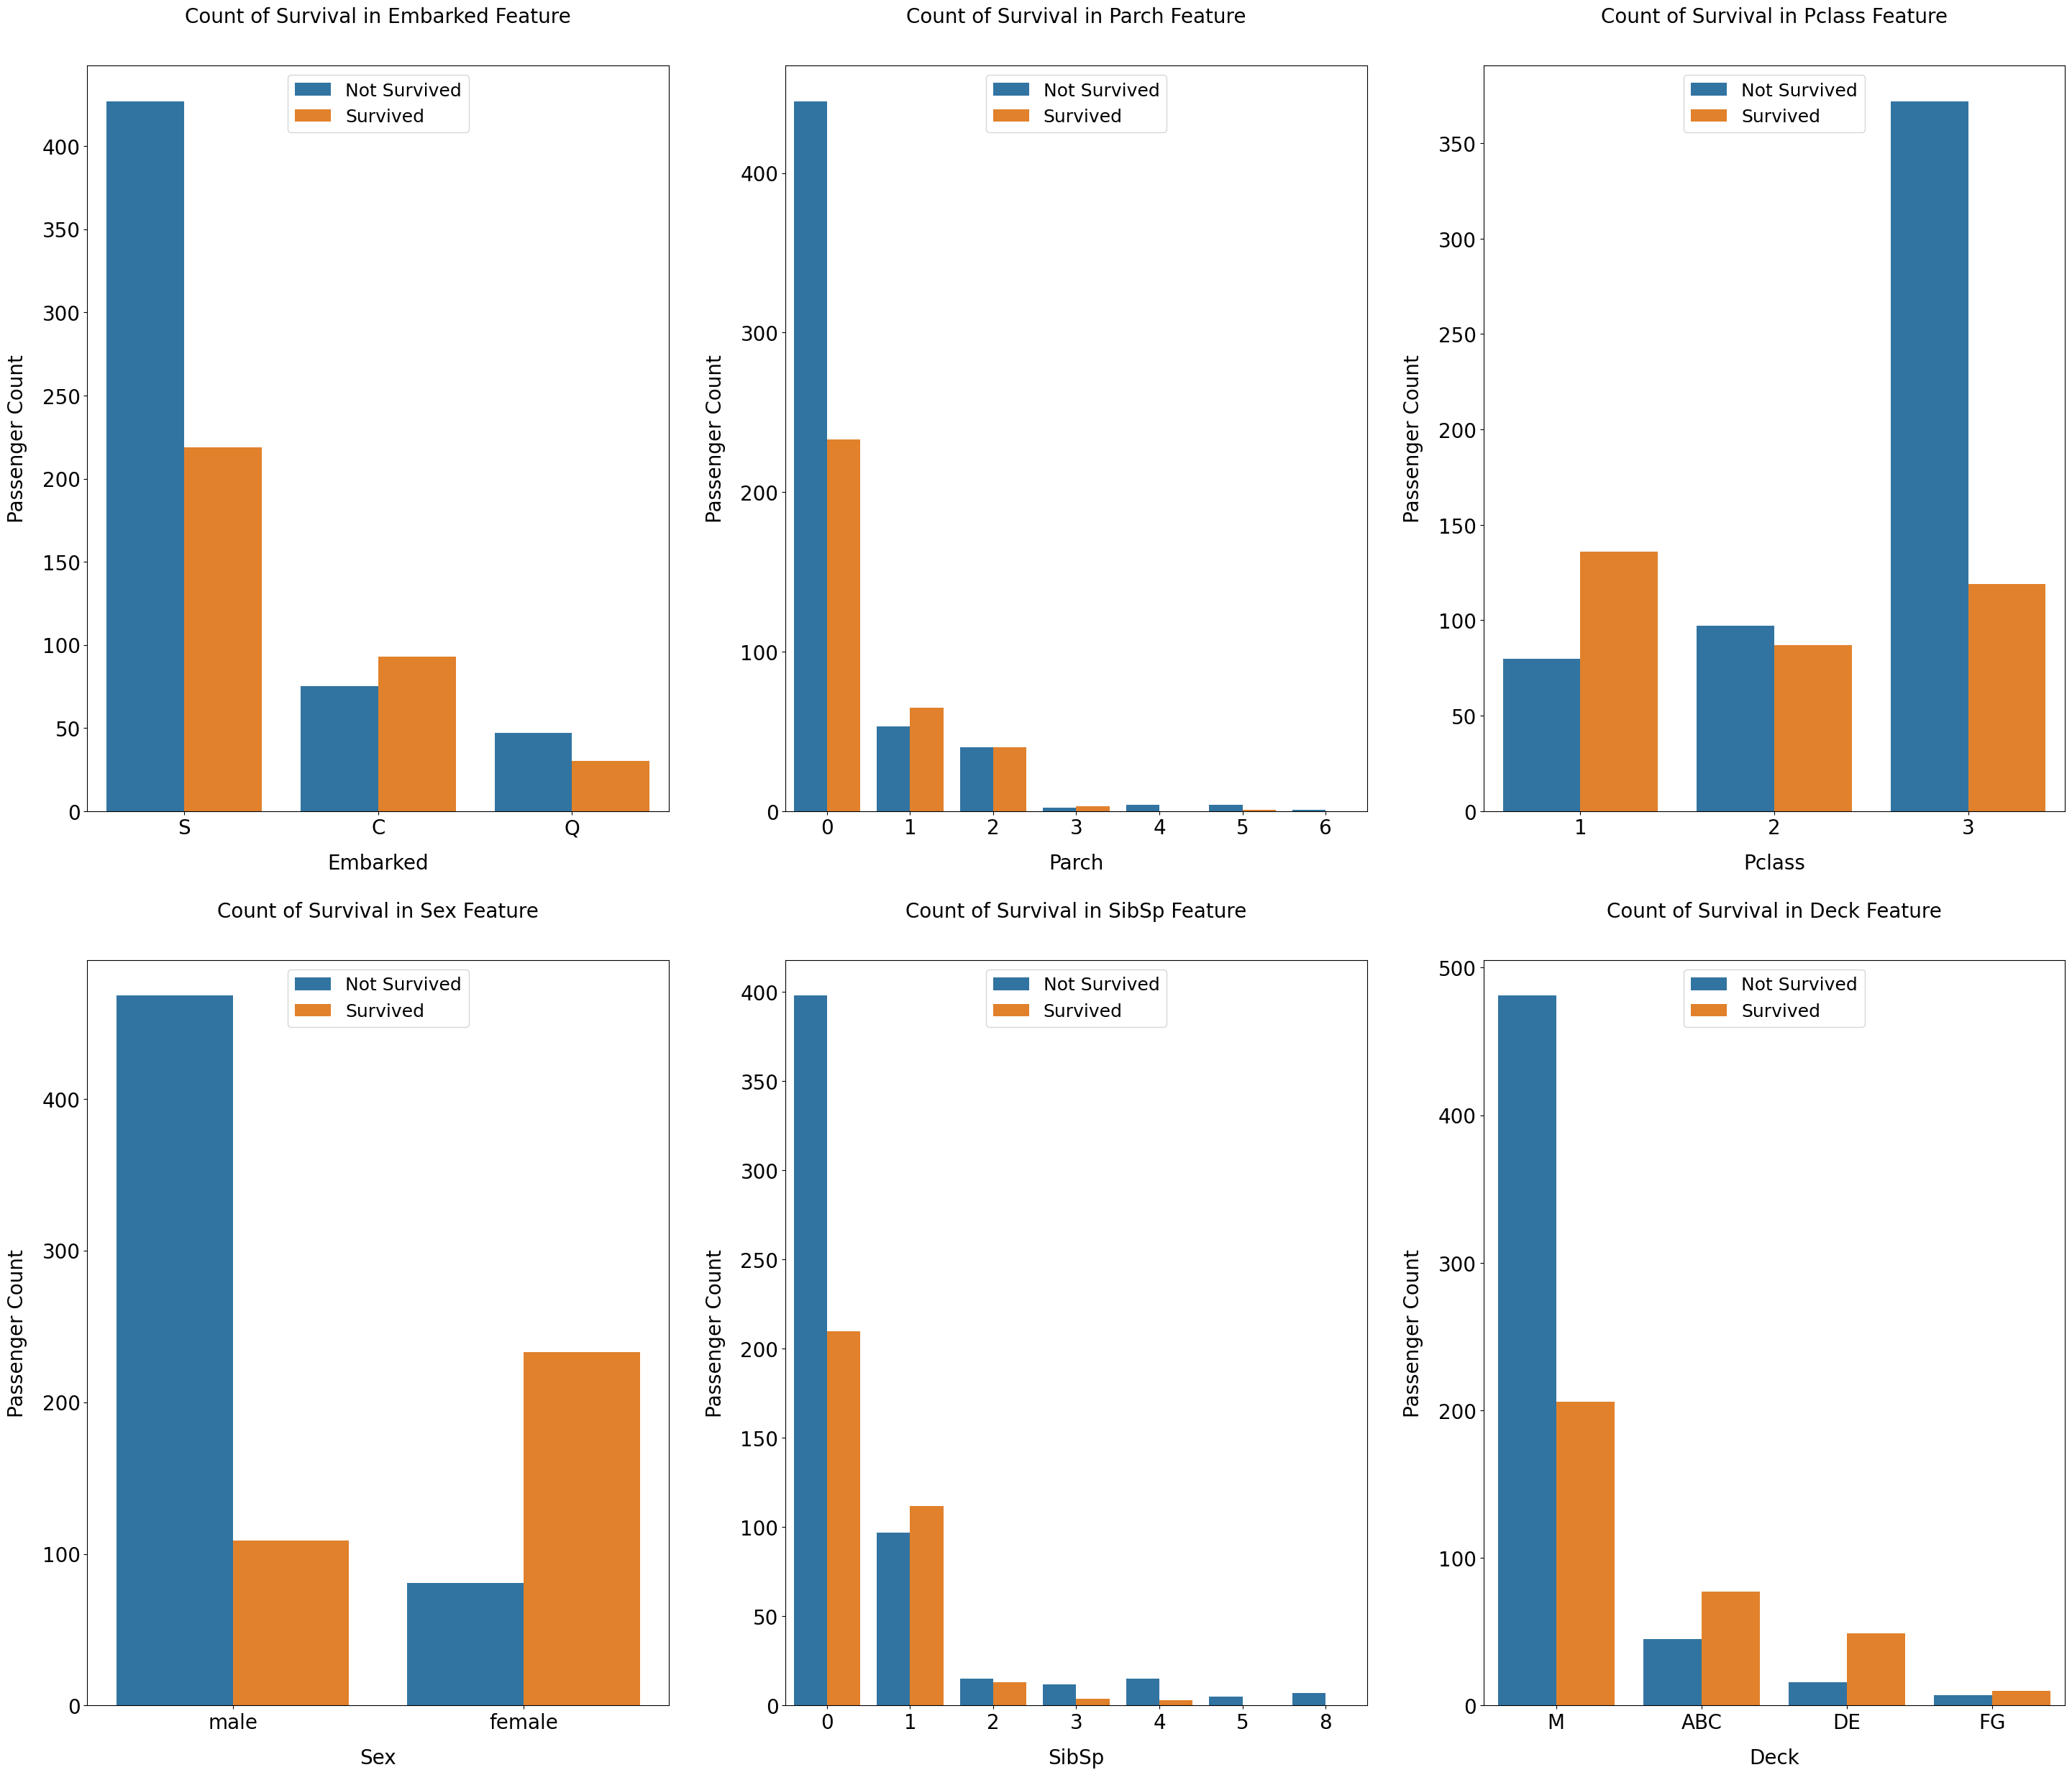

In [26]:
cat_features = ['Embarked', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Deck']

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(20, 20))
plt.subplots_adjust(right=1.5, top=1.25)

for i, feature in enumerate(cat_features, 1):    
    plt.subplot(2, 3, i)
    sns.countplot(x=feature, hue='Survived', data=train_data)
    
    plt.xlabel('{}'.format(feature), size=20, labelpad=15)
    plt.ylabel('Passenger Count', size=20, labelpad=15)    
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    
    plt.legend(['Not Survived', 'Survived'], loc='upper center', prop={'size': 18})
    plt.title('Count of Survival in {} Feature'.format(feature), size=20, y=1.05)

plt.show()

### **1.5 Conclusion**
Most of the features are correlated with each other. This relationship can be used to create new features with feature transformation and feature interaction. Target encoding could be very useful as well because of the high correlations with `Survived` feature.

Split points and spikes are visible in continuous features. They can be captured easily with a decision tree model, but linear models may not be able to spot them.

Categorical features have very distinct distributions with different survival rates. Those features can be one-hot encoded. Some of those features may be combined with each other to make new features.

Created a new feature called `Deck` and dropped `Cabin` feature at the **Exploratory Data Analysis** part.

In [27]:
dt_all = concat_data(train_data, test_data)
dt_all.head()

,Age,Deck,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,M,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,ABC,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,M,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,ABC,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,M,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


## **2. Feature Engineering**
### **2.1 Binning Continuous Features**
#### **2.1.1 Fare**
`Fare` feature is positively skewed and survival rate is extremely high on the right end. **13** quantile based bins are used for `Fare` feature. Even though the bins are too much, they provide decent amount of information gain. The groups at the left side of the graph has the lowest survival rate and the groups at the right side of the graph has the highest survival rate. This high survival rate was not visible in the distribution graph. There is also an unusual group **(15.742, 23.25]** in the middle with high survival rate that is captured in this process.

In [28]:
dt_all['Fare'] = pd.qcut(dt_all['Fare'],13)

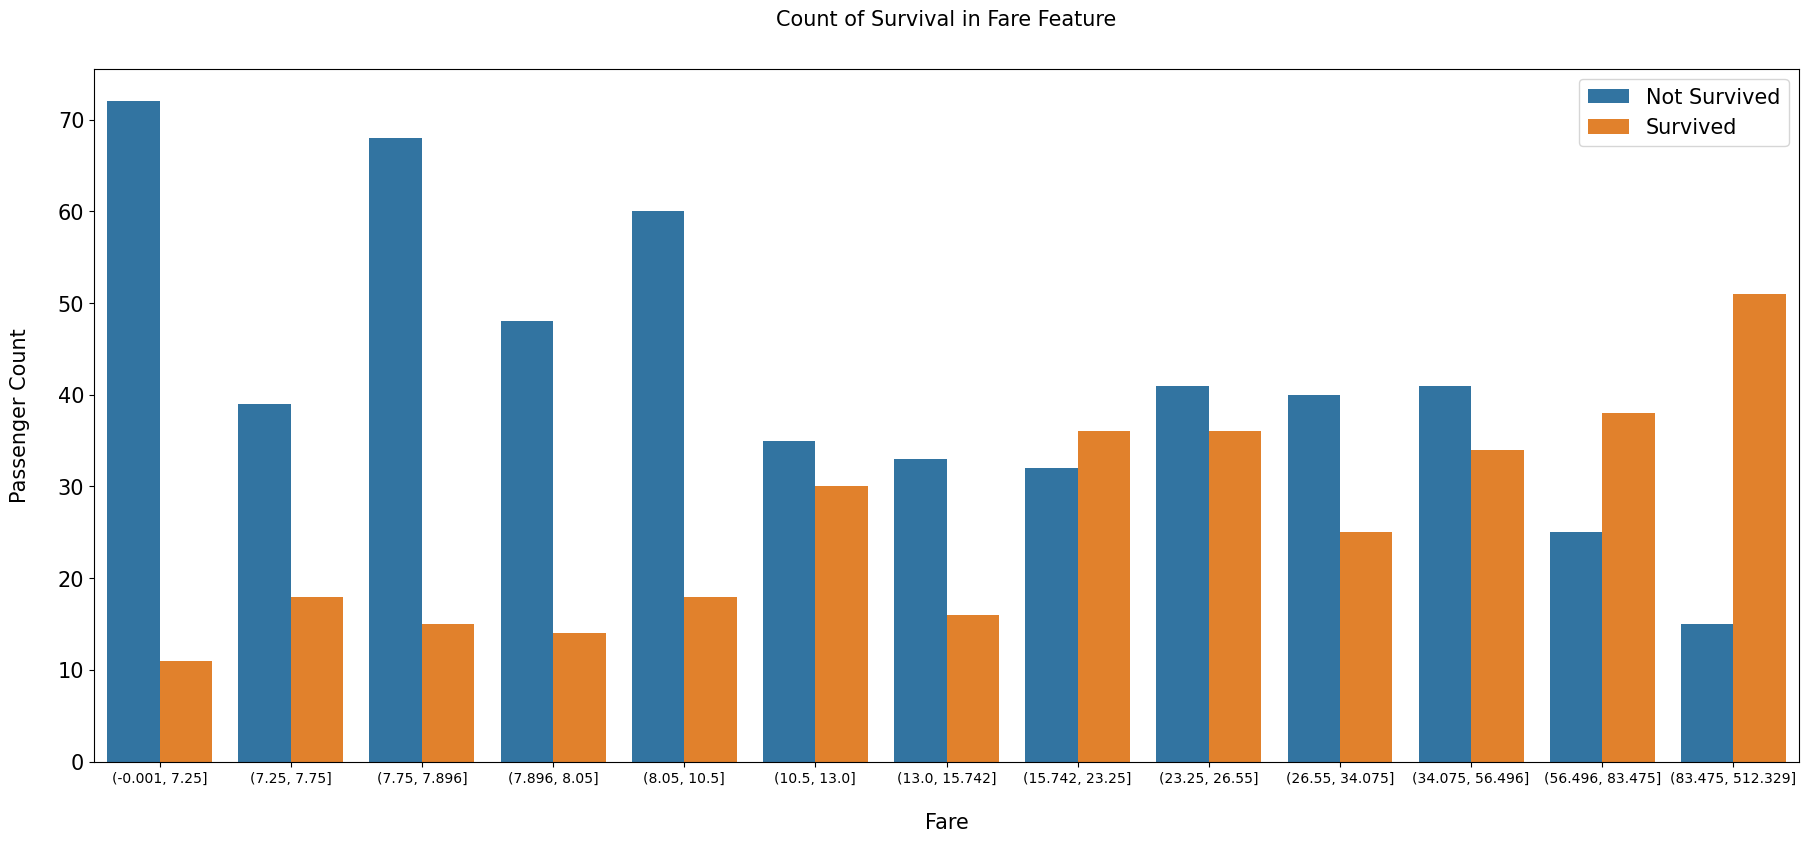

In [29]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Fare', hue='Survived', data=dt_all)

plt.xlabel('Fare', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Fare'), size=15, y=1.05)

plt.show()

#### **2.1.2 Age**
`Age` feature has a normal distribution with some spikes and bumps and **10** quantile based bins are used for `Age`. The first bin has the highest survival rate and 4th bin has the lowest survival rate. Those were the biggest spikes in the distribution. There is also an unusual group **(34.0, 40.0]** with high survival rate that is captured in this process.

In [30]:
dt_all['Age'] = pd.qcut(dt_all['Age'], 10)

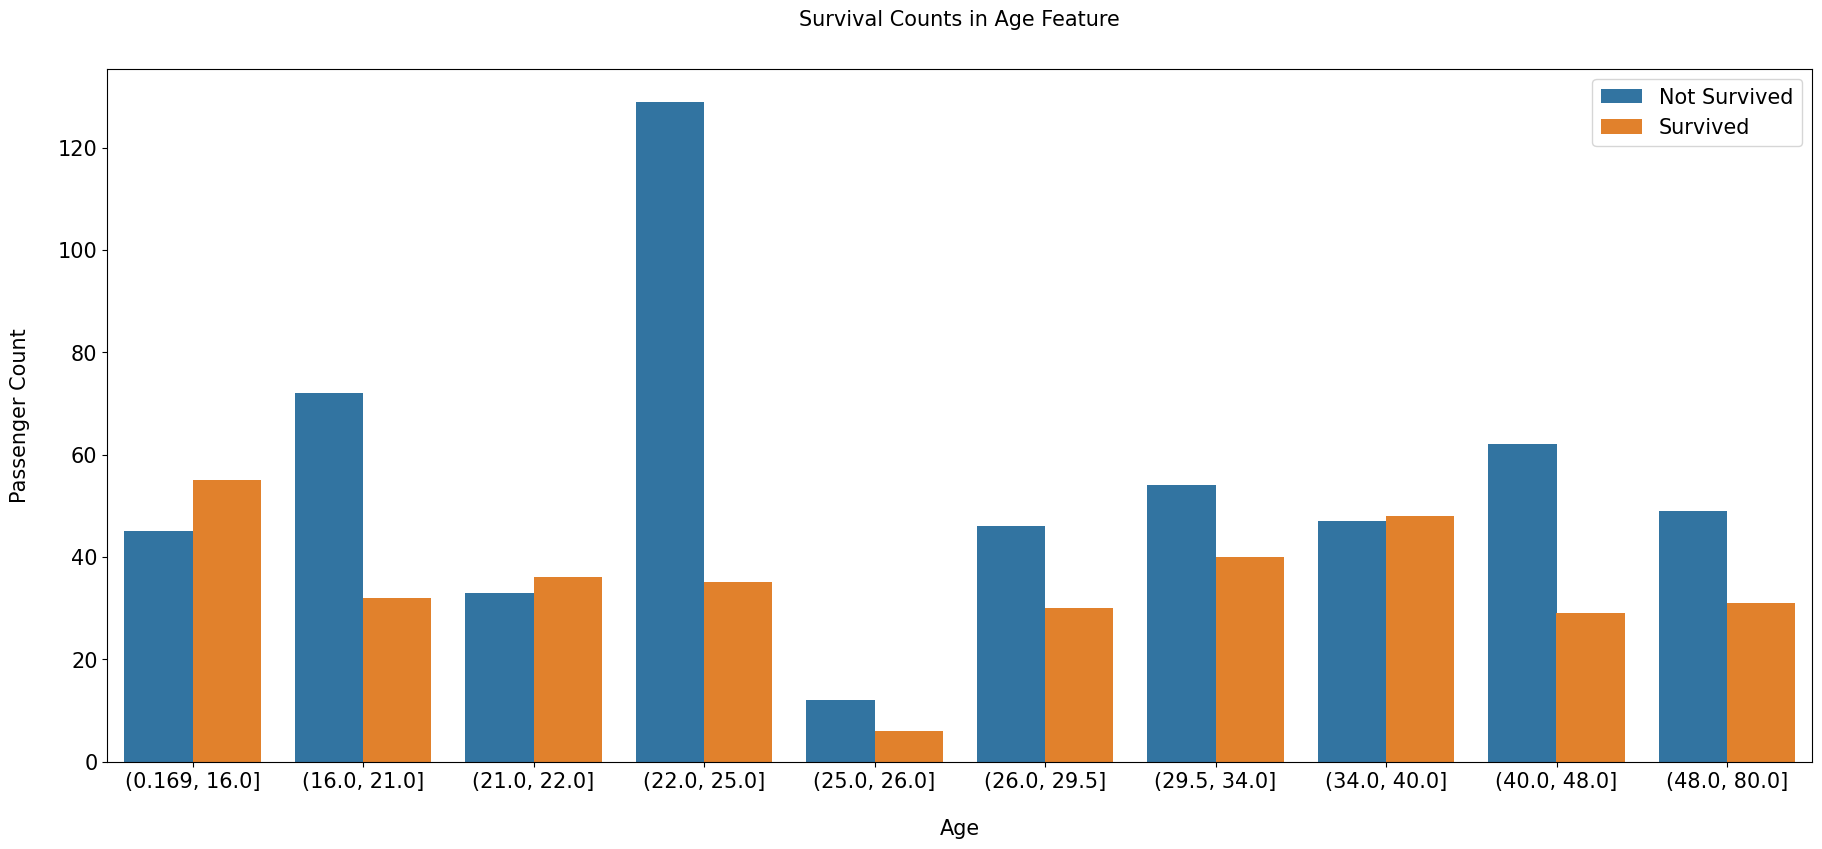

In [31]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Age', hue='Survived', data=dt_all)

plt.xlabel('Age', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Survival Counts in {} Feature'.format('Age'), size=15, y=1.05)

plt.show()

### **2.2 Frequency Encoding**
`Family_Size` is created by adding `SibSp`, `Parch` and **1**. `SibSp` is the count of siblings and spouse, and `Parch` is the count of parents and children. Those columns are added in order to find the total size of families. Adding **1** at the end, is the current passenger. Graphs have clearly shown that family size is a predictor of survival because different values have different survival rates.
* Family Size with **1** are labeled as **Alone**
* Family Size with **2**, **3** and **4** are labeled as **Small**
* Family Size with **5** and **6** are labeled as **Medium**
* Family Size with **7**, **8** and **11** are labeled as **Large**

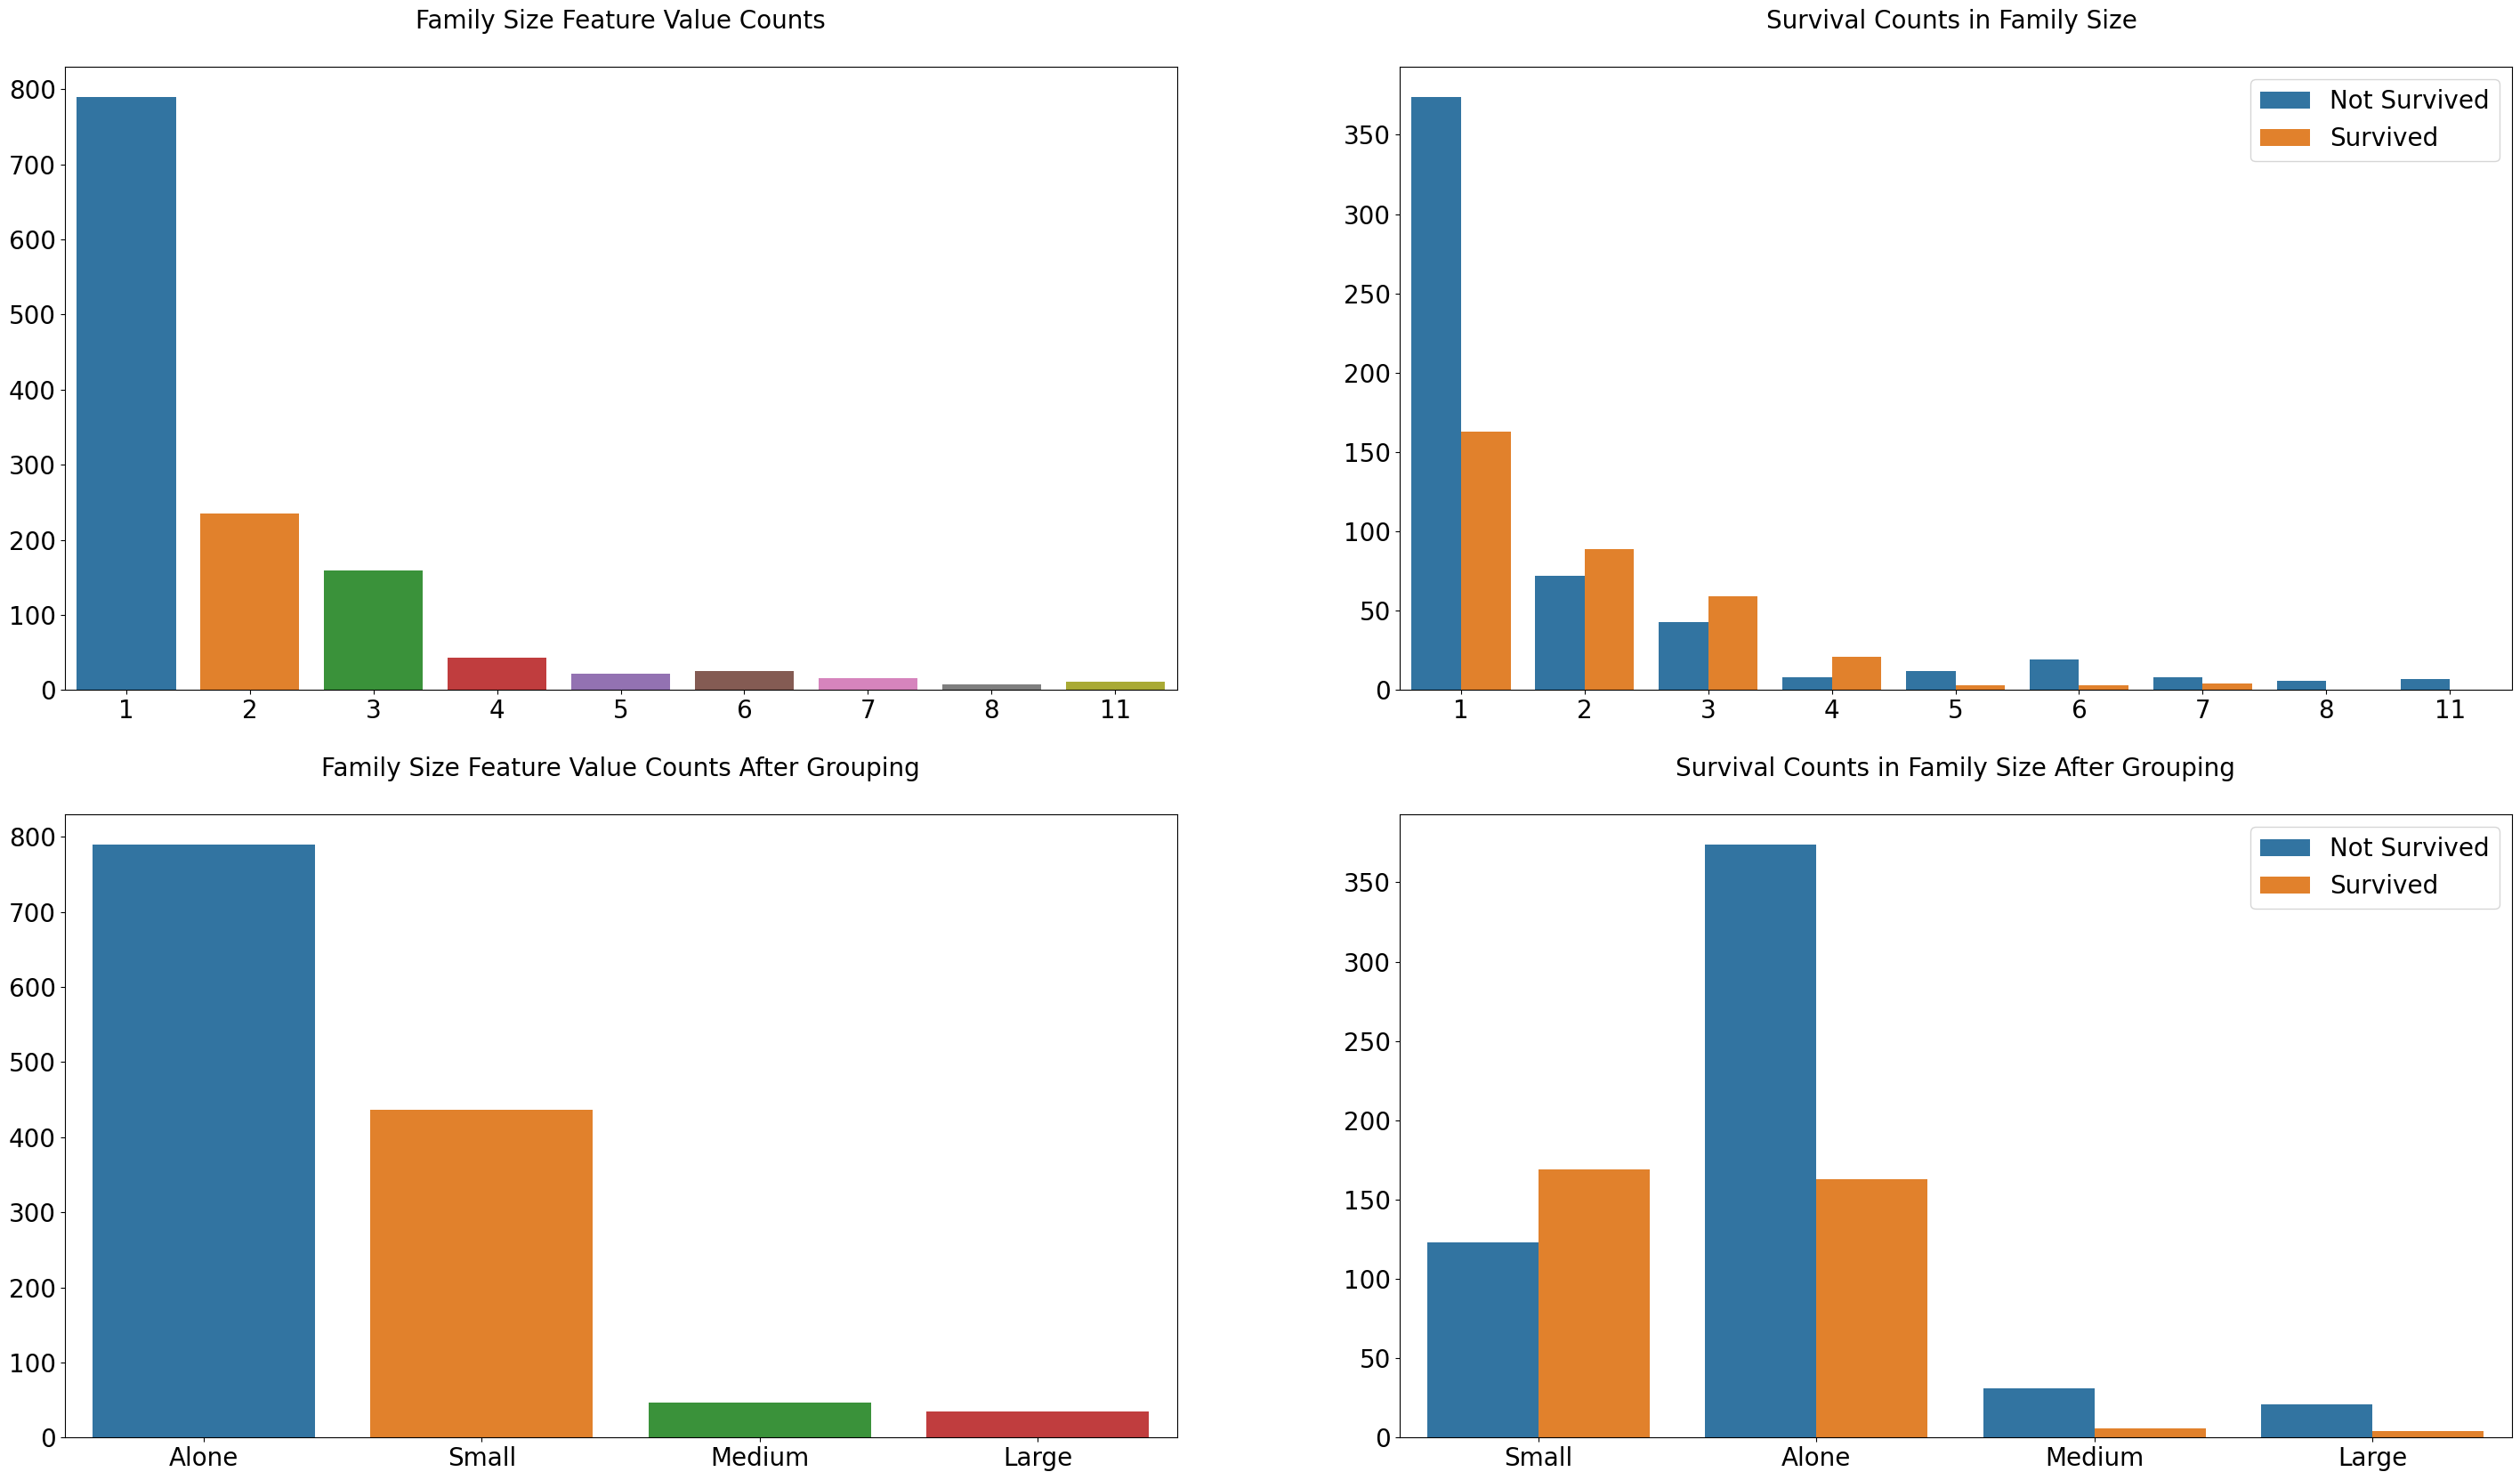

In [32]:
dt_all['Family_Size'] = dt_all['SibSp'] + dt_all['Parch'] + 1

fig, axs = plt.subplots(figsize=(20, 20), ncols=2, nrows=2)
plt.subplots_adjust(right=1.5)

sns.barplot(x=dt_all['Family_Size'].value_counts().index, y=dt_all['Family_Size'].value_counts().values, ax=axs[0][0])
sns.countplot(x='Family_Size', hue='Survived', data=dt_all, ax=axs[0][1])

axs[0][0].set_title('Family Size Feature Value Counts', size=20, y=1.05)
axs[0][1].set_title('Survival Counts in Family Size ', size=20, y=1.05)

family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
dt_all['Family_Size_Grouped'] = dt_all['Family_Size'].map(family_map)

sns.barplot(x=dt_all['Family_Size_Grouped'].value_counts().index, y=dt_all['Family_Size_Grouped'].value_counts().values, ax=axs[1][0])
sns.countplot(x='Family_Size_Grouped', hue='Survived', data=dt_all, ax=axs[1][1])

axs[1][0].set_title('Family Size Feature Value Counts After Grouping', size=20, y=1.05)
axs[1][1].set_title('Survival Counts in Family Size After Grouping', size=20, y=1.05)

for i in range(2):
    axs[i][1].legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 20})
    for j in range(2):
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
        axs[i][j].set_xlabel('')
        axs[i][j].set_ylabel('')

plt.show()

There are too many unique `Ticket` values to analyze, so grouping them up by their frequencies makes things easier.

**How is this feature different than `Family_Size`?** Many passengers travelled along with groups. Those groups consist of friends, nannies, maids and etc. They weren't counted as family, but they used the same ticket.

**Why not grouping tickets by their prefixes?** If prefixes in `Ticket` feature has any meaning, then they are already captured in `Pclass` or `Embarked` features because that could be the only logical information which can be derived from the `Ticket` feature.

According to the graph below, groups with **2**,**3** and **4** members had a higher survival rate. Passengers who travel alone has the lowest survival rate. After **4** group members, survival rate decreases drastically. This pattern is very similar to `Family_Size` feature but there are minor differences. `Ticket_Frequency` values are not grouped like `Family_Size` because that would basically create the same feature with perfect correlation. This kind of feature wouldn't provide any additional information gain.

In [33]:
dt_all['Ticket_Frequency'] = dt_all.groupby('Ticket')['Ticket'].transform('count')

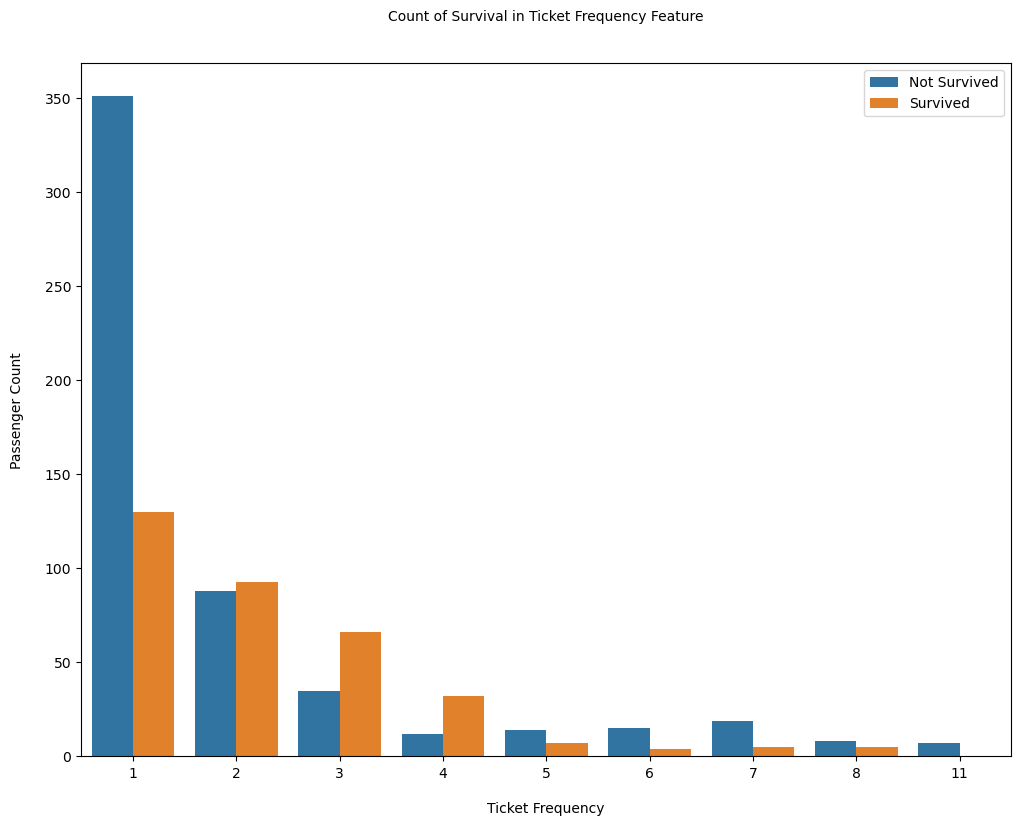

In [34]:
fig, axs = plt.subplots(figsize=(12, 9))
sns.countplot(x='Ticket_Frequency', hue='Survived', data=dt_all)

plt.xlabel('Ticket Frequency', size=10, labelpad=15)
plt.ylabel('Passenger Count', size=10, labelpad=15)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 10})
plt.title('Count of Survival in {} Feature'.format('Ticket Frequency'), size=10, y=1.05)

plt.show()

### **2.3 Title & Is Married**
`Title` is created by extracting the prefix before `Name` feature. According to graph below, there are many titles that are occuring very few times. Some of those titles doesn't seem correct and they need to be replaced. **Miss**, **Mrs**, **Ms**, **Mlle**, **Lady**, **Mme**, **the Countess**, **Dona** titles are replaced with **Miss/Mrs/Ms** because all of them are female. Values like **Mlle**, **Mme** and **Dona** are actually the name of the passengers, but they are classified as titles because `Name` feature is split by comma. **Dr**, **Col**, **Major**, **Jonkheer**, **Capt**, **Sir**, **Don** and **Rev** titles are replaced with **Dr/Military/Noble/Clergy** because those passengers have similar characteristics. **Master** is a unique title. It is given to male passengers below age **26**. They have the highest survival rate among all males.

`Is_Married` is a binary feature based on the **Mrs** title. **Mrs** title has the highest survival rate among other female titles. This title needs to be a feature because all female titles are grouped with each other.

In [35]:
dt_all['Title'] = dt_all['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
dt_all['Is_Married'] = 0
dt_all['Is_Married'].loc[dt_all['Title'] == 'Mrs'] = 1

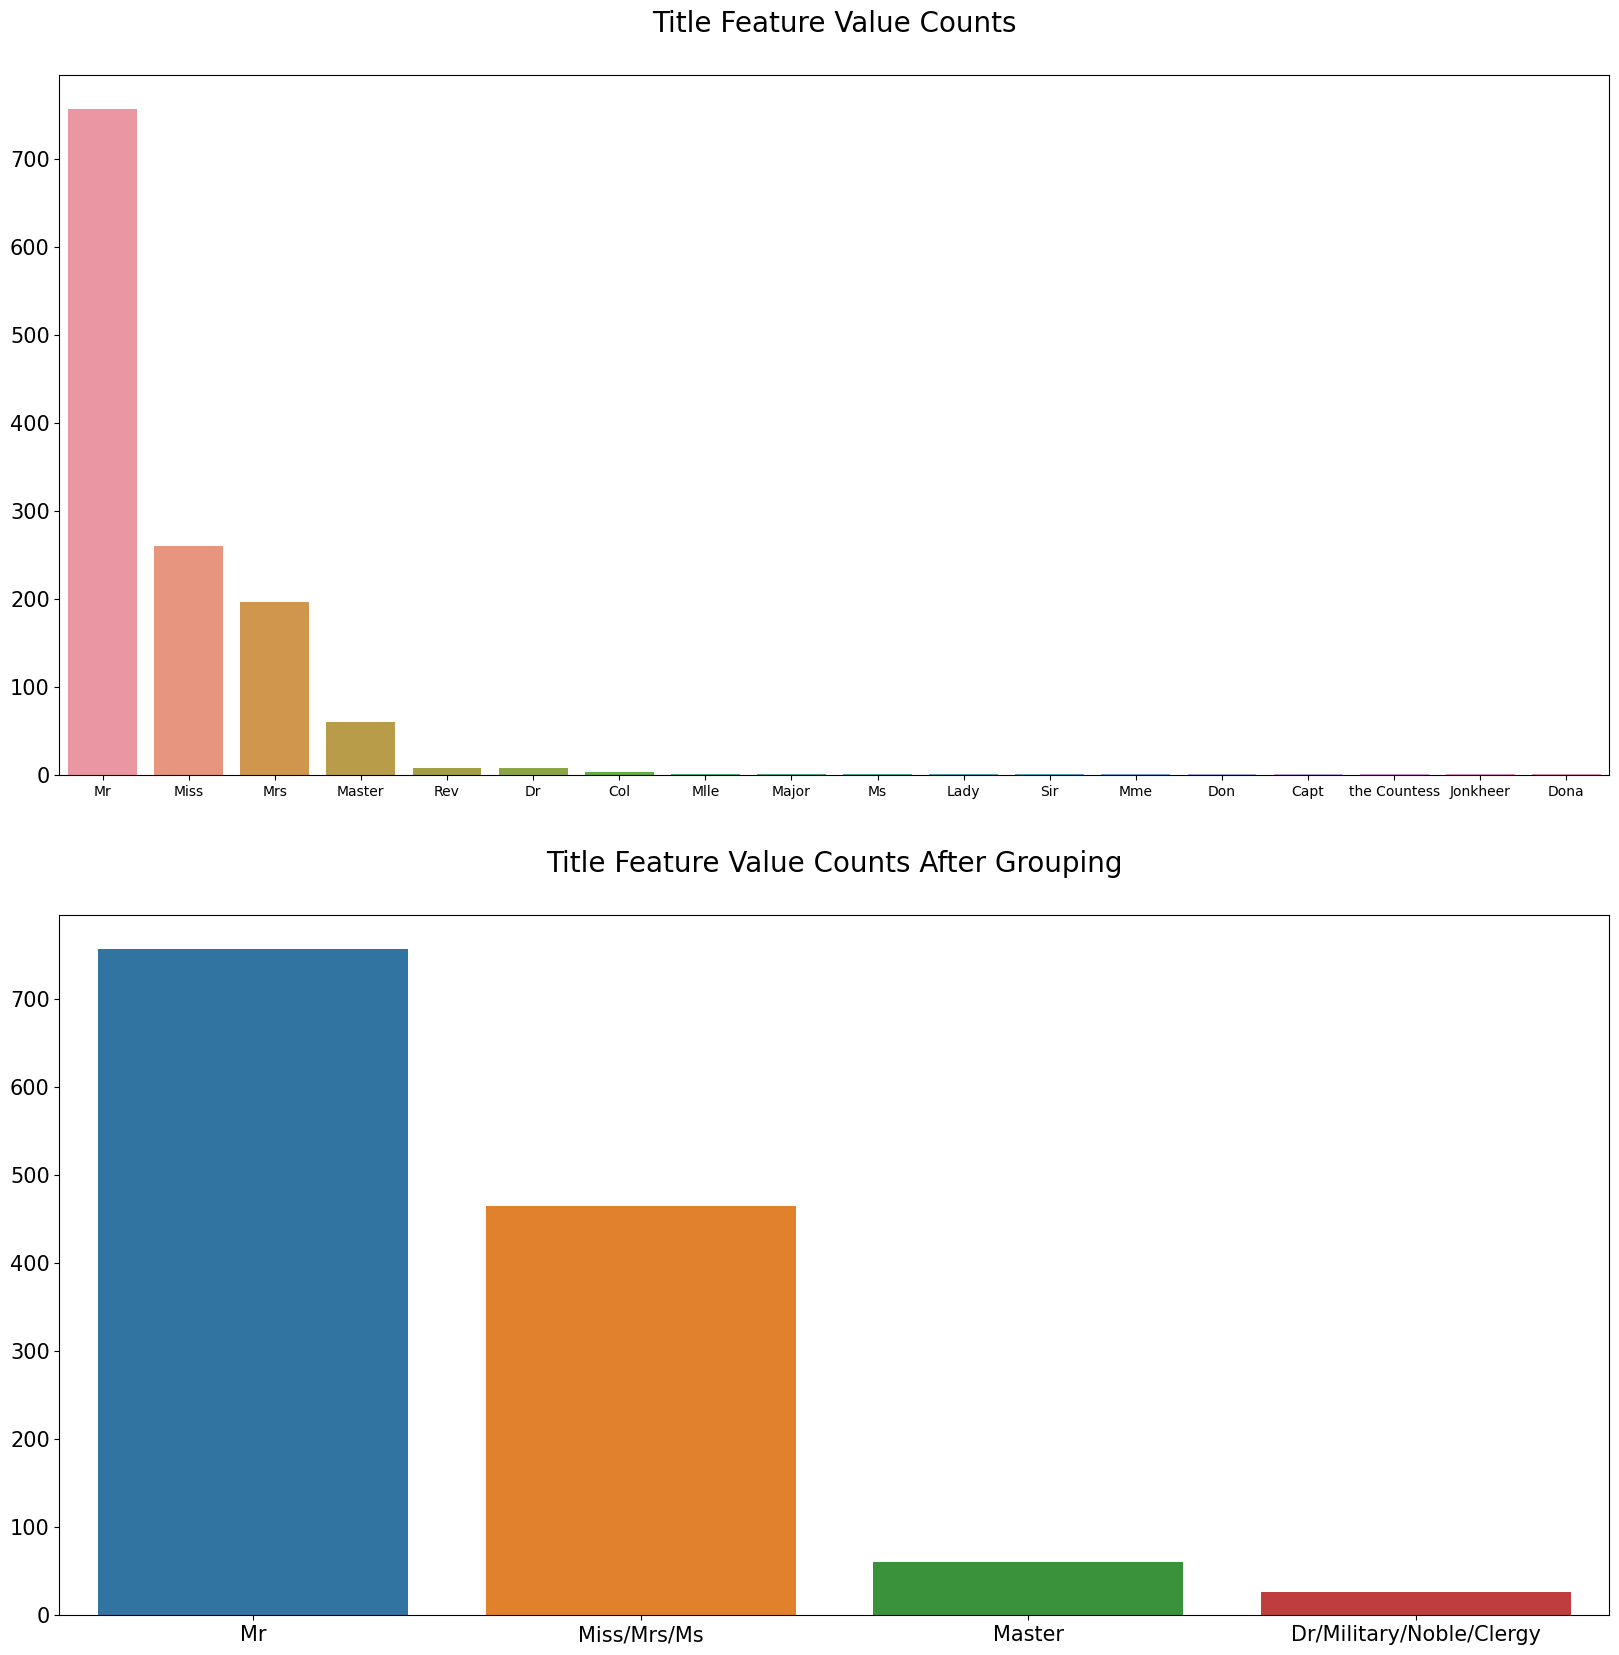

In [36]:
fig, axs = plt.subplots(nrows=2, figsize=(20, 20))
sns.barplot(x=dt_all['Title'].value_counts().index, y=dt_all['Title'].value_counts().values, ax=axs[0])

axs[0].tick_params(axis='x', labelsize=10)
axs[1].tick_params(axis='x', labelsize=15)

for i in range(2):    
    axs[i].tick_params(axis='y', labelsize=15)

axs[0].set_title('Title Feature Value Counts', size=20, y=1.05)

dt_all['Title'] = dt_all['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
dt_all['Title'] = dt_all['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')

sns.barplot(x=dt_all['Title'].value_counts().index, y=dt_all['Title'].value_counts().values, ax=axs[1])
axs[1].set_title('Title Feature Value Counts After Grouping', size=20, y=1.05)

plt.show()

### **2.4 Target Encoding**
`extract_surname` function is used for extracting surnames of passengers from the `Name` feature. `Family` feature is created with the extracted surname. This is necessary for grouping passengers in the same family. 

In [37]:
print(dt_all['Name'])

0                                 Braund, Mr. Owen Harris
1       Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                  Heikkinen, Miss. Laina
3            Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                                Allen, Mr. William Henry
                              ...                        
1304                                   Spector, Mr. Woolf
1305                         Oliva y Ocana, Dona. Fermina
1306                         Saether, Mr. Simon Sivertsen
1307                                  Ware, Mr. Frederick
1308                             Peter, Master. Michael J
Name: Name, Length: 1309, dtype: object


In [38]:
def extract_surname(data):    
    
    families = []
    
    for i in range(len(data)):        
        name = data.iloc[i]
        if '(' in name:
            name_no_bracket = name.split('(')[0] 
        else:
            name_no_bracket = name
            
        family = name_no_bracket.split(',')[0]
        title = name_no_bracket.split(',')[1].strip().split(' ')[0]
        
        for c in string.punctuation:
            family = family.replace(c, '').strip()
            
        families.append(family)
            
    return families

dt_all['Family'] = extract_surname(dt_all['Name'])
train_data = dt_all.loc[:890]
test_data = dt_all.loc[891:]
dts = [train_data, test_data]

`Family_Survival_Rate` is calculated from families in training set since there is no `Survived` feature in test set. A list of family names that are occuring in both training and test set (`non_unique_families`), is created. The survival rate is calculated for families with more than 1 members in that list, and stored in `Family_Survival_Rate` feature.

An extra binary feature `Family_Survival_Rate_NA` is created for families that are unique to the test set. This feature is also necessary because there is no way to calculate those families' survival rate. This feature implies that family survival rate is not applicable to those passengers because there is no way to retrieve their survival rate.

`Ticket_Survival_Rate` and `Ticket_Survival_Rate_NA` features are also created with the same method. `Ticket_Survival_Rate` and `Family_Survival_Rate` are averaged and become `Survival_Rate`, and `Ticket_Survival_Rate_NA` and `Family_Survival_Rate_NA` are also averaged and become `Survival_Rate_NA`.

In [39]:
# Creating a list of families and tickets that are occuring in both training and test set
non_unique_families = [x for x in train_data['Family'].unique() if x in test_data['Family'].unique()]
non_unique_tickets = [x for x in train_data['Ticket'].unique() if x in test_data['Ticket'].unique()]

df_family_survival_rate = train_data.groupby('Family')['Survived', 'Family','Family_Size'].median()
df_ticket_survival_rate = train_data.groupby('Ticket')['Survived', 'Ticket','Ticket_Frequency'].median()

family_rates = {}
ticket_rates = {}

for i in range(len(df_family_survival_rate)):
    # Checking a family exists in both training and test set, and has members more than 1
    if df_family_survival_rate.index[i] in non_unique_families and df_family_survival_rate.iloc[i, 1] > 1:
        family_rates[df_family_survival_rate.index[i]] = df_family_survival_rate.iloc[i, 0]

for i in range(len(df_ticket_survival_rate)):
    # Checking a ticket exists in both training and test set, and has members more than 1
    if df_ticket_survival_rate.index[i] in non_unique_tickets and df_ticket_survival_rate.iloc[i, 1] > 1:
        ticket_rates[df_ticket_survival_rate.index[i]] = df_ticket_survival_rate.iloc[i, 0]

In [40]:
mean_survival_rate = np.mean(train_data['Survived'])

train_family_survival_rate = []
train_family_survival_rate_NA = []
test_family_survival_rate = []
test_family_survival_rate_NA = []

for i in range(len(train_data)):
    if train_data['Family'][i] in family_rates:
        train_family_survival_rate.append(family_rates[train_data['Family'][i]])
        train_family_survival_rate_NA.append(1)
    else:
        train_family_survival_rate.append(mean_survival_rate)
        train_family_survival_rate_NA.append(0)
        
for i in range(len(test_data)):
    if test_data['Family'].iloc[i] in family_rates:
        test_family_survival_rate.append(family_rates[test_data['Family'].iloc[i]])
        test_family_survival_rate_NA.append(1)
    else:
        test_family_survival_rate.append(mean_survival_rate)
        test_family_survival_rate_NA.append(0)
        
train_data['Family_Survival_Rate'] = train_family_survival_rate
train_data['Family_Survival_Rate_NA'] = train_family_survival_rate_NA
test_data['Family_Survival_Rate'] = test_family_survival_rate
test_data['Family_Survival_Rate_NA'] = test_family_survival_rate_NA

train_ticket_survival_rate = []
train_ticket_survival_rate_NA = []
test_ticket_survival_rate = []
test_ticket_survival_rate_NA = []

for i in range(len(train_data)):
    if train_data['Ticket'][i] in ticket_rates:
        train_ticket_survival_rate.append(ticket_rates[train_data['Ticket'][i]])
        train_ticket_survival_rate_NA.append(1)
    else:
        train_ticket_survival_rate.append(mean_survival_rate)
        train_ticket_survival_rate_NA.append(0)
        
for i in range(len(test_data)):
    if test_data['Ticket'].iloc[i] in ticket_rates:
        test_ticket_survival_rate.append(ticket_rates[test_data['Ticket'].iloc[i]])
        test_ticket_survival_rate_NA.append(1)
    else:
        test_ticket_survival_rate.append(mean_survival_rate)
        test_ticket_survival_rate_NA.append(0)
        
train_data['Ticket_Survival_Rate'] = train_ticket_survival_rate
train_data['Ticket_Survival_Rate_NA'] = train_ticket_survival_rate_NA
test_data['Ticket_Survival_Rate'] = test_ticket_survival_rate
test_data['Ticket_Survival_Rate_NA'] = test_ticket_survival_rate_NA

In [41]:
for dt in [train_data, test_data]:
    dt['Survival_Rate'] = (dt['Ticket_Survival_Rate'] + dt['Family_Survival_Rate']) / 2
    dt['Survival_Rate_NA'] = (dt['Ticket_Survival_Rate_NA'] + dt['Family_Survival_Rate_NA']) / 2    

### **2.5 Feature Transformation**

#### **2.5.1 Label Encoding Non-Numerical Features**
`Embarked`, `Sex`, `Deck` , `Title` and `Family_Size_Grouped` are object type, and `Age` and `Fare` features are category type. They are converted to numerical type with `LabelEncoder`. `LabelEncoder` basically labels the classes from **0** to **n**. This process is necessary for models to learn from those features.

In [42]:
non_numeric_features = ['Embarked', 'Sex', 'Deck', 'Title', 'Family_Size_Grouped', 'Age', 'Fare']

for dt in dts:
    for feature in non_numeric_features:        
        dt[feature] = LabelEncoder().fit_transform(dt[feature])

#### **2.5.2 One-Hot Encoding the Categorical Features**

The categorical features (`Pclass`, `Sex`, `Deck`, `Embarked`, `Title`) are converted to one-hot encoded features with `OneHotEncoder`. `Age` and `Fare` features are not converted because they are ordinal unlike the previous ones.

In [43]:
categorical_features = ['Pclass', 'Sex', 'Deck', 'Embarked', 'Title', 'Family_Size_Grouped']
encoded_features = []

for dt in dts:
    for feature in categorical_features:
        encoded_feat = OneHotEncoder().fit_transform(dt[feature].values.reshape(-1, 1)).toarray()
        n = dt[feature].nunique()
        cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
        encoded_dt = pd.DataFrame(encoded_feat, columns=cols)
        encoded_dt.index = dt.index
        encoded_features.append(encoded_dt)

train_data = pd.concat([train_data, *encoded_features[:6]], axis=1)
test_data = pd.concat([test_data, *encoded_features[6:]], axis=1)

### **2.6 Conclusion**

`Age` and `Fare` features are binned. Binning helped dealing with outliers and it revealed some homogeneous groups in those features. `Family_Size` is created by adding `Parch` and `SibSp` features and **1**. `Ticket_Frequency` is created by counting the occurence of `Ticket` values.

`Name` feature is very useful. First, `Title` and `Is_Married` features are created from the title prefix in the names. Second, `Family_Survival_Rate` and `Family_Survival_Rate_NA`  features are created by target encoding the surname of the passengers. `Ticket_Survival_Rate` is created by target encoding the `Ticket` feature. `Survival_Rate` feature is created by averaging the `Family_Survival_Rate` and `Ticket_Survival_Rate` features.

Finally, the non-numeric type features are label encoded and categorical features are one-hot encoded. Created **5** new features (`Family_Size`, `Title`, `Is_Married`, `Survival_Rate` and `Survival_Rate_NA`) and dropped the useless features after encoding.

In [44]:
dt_all = concat_data(train_data, test_data)
drop_columns = ['Deck', 'Embarked', 'Family', 'Family_Size', 'Family_Size_Grouped', 'Survived',
             'Name', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Ticket', 'Title',
            'Ticket_Survival_Rate', 'Family_Survival_Rate', 'Ticket_Survival_Rate_NA', 'Family_Survival_Rate_NA']

dt_all.drop(columns=drop_columns, inplace=True)

dt_all.head()

,Age,Deck_1,Deck_2,Deck_3,Deck_4,Embarked_1,Embarked_2,Embarked_3,Family_Size_Grouped_1,Family_Size_Grouped_2,...,Pclass_3,Sex_1,Sex_2,Survival_Rate,Survival_Rate_NA,Ticket_Frequency,Title_1,Title_2,Title_3,Title_4
0,2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.383838,0.0,1,0.0,0.0,0.0,1.0
1,7,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.000000,1.0,2,0.0,0.0,1.0,0.0
2,4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,1.0,0.0,0.383838,0.0,1,0.0,0.0,1.0,0.0
3,7,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.383838,0.0,2,0.0,0.0,1.0,0.0
4,7,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.383838,0.0,1,0.0,0.0,0.0,1.0


## **3. ML Models**

We will train 5 Machine Learning models and compare their results. 

1. **Randomforest**
2. **Decision tree**
3. ** **
4. ** **
5. ** **

Note that because the dataset does not provide labels for their testing-set, we need to use the predictions on the training set to compare the algorithms with each other. Later on, we will use cross validation.

In [45]:
X_train = StandardScaler().fit_transform(train_data.drop(columns=drop_columns))
y_train = train_data['Survived'].values
X_test = StandardScaler().fit_transform(test_data.drop(columns=drop_columns))

print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))

X_train shape: (891, 26)
y_train shape: (891,)
X_test shape: (418, 26)


In [46]:
X_test

array([[ 0.93885142, -1.01419247, -0.60813278, ..., -0.15655607,
        -0.15655607, -0.72879046],
       [ 1.28893161, -1.5359555 , -0.60813278, ..., -0.15655607,
        -0.15655607,  1.37213652],
       [ 1.63901181, -0.49242945, -0.60813278, ..., -0.15655607,
        -0.15655607, -0.72879046],
       ...,
       [ 0.93885142, -1.5359555 , -0.60813278, ..., -0.15655607,
        -0.15655607, -0.72879046],
       [-0.46146934, -0.75331096, -0.60813278, ..., -0.15655607,
        -0.15655607, -0.72879046],
       [-0.46146934,  0.29021508,  0.53949477, ..., -0.15655607,
        -0.15655607,  1.37213652]])

### **3.1 Random Forest**

Created 2 `RandomForestClassifier`'s. One of them is a single model and the other is for k-fold cross validation.

The highest accuracy of the `single_best_model` is **0.82775** in public leaderboard. However, it doesn't perform better in k-fold cross validation. It is a good model to start experimenting and hyperparameter tuning.

The highest accuracy of `leaderboard_model` is **0.83732** in public leaderboard with 5-fold cross validation. This model is created for leaderboard score and it is tuned to overfit slightly. It is designed to overfit because the estimated probabilities of `X_test` in every fold are going to be divided by **N** (fold count). If this model is used as a single model, it would struggle to predict lots of samples correctly.

**Which model should I use?** 
* `leaderboard_rf_model` overfits to test set so it's not suggested to use models like this in real life projects.
* `single_best_rf_model` is a good model to start experimenting and learning about decision trees.

In [47]:
single_best_rf_model = RandomForestClassifier(criterion='gini', 
                                           n_estimators=1100,
                                           max_depth=5,
                                           min_samples_split=4,
                                           min_samples_leaf=5,
                                           max_features='auto',
                                           oob_score=True,
                                           random_state=SEED,
                                           n_jobs=-1,
                                           verbose=1)

leaderboard_rf_model = RandomForestClassifier(criterion='gini',
                                           n_estimators=1750,
                                           max_depth=7,
                                           min_samples_split=6,
                                           min_samples_leaf=6,
                                           max_features='auto',
                                           oob_score=True,
                                           random_state=SEED,
                                           n_jobs=-1,
                                           verbose=1) 

`StratifiedKFold` is used for stratifying the target variable. The folds are made by preserving the percentage of samples for each class in target variable (`Survived`).

In [48]:
N = 5
oob = 0
probs = pd.DataFrame(np.zeros((len(X_test), N * 2)), columns=['Fold_{}_Prob_{}'.format(i, j) for i in range(1, N + 1) for j in range(2)])
importances = pd.DataFrame(np.zeros((X_train.shape[1], N)), columns=['Fold_{}'.format(i) for i in range(1, N + 1)], index=dt_all.columns)
fprs, tprs, scores = [], [], []

skf = StratifiedKFold(n_splits=N, random_state=N, shuffle=True)

for fold, (trn_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    print('Fold {}\n'.format(fold))
    
    # Fitting the model
    leaderboard_rf_model.fit(X_train[trn_idx], y_train[trn_idx])
    
    # Computing Train AUC score
    trn_fpr, trn_tpr, trn_thresholds = roc_curve(y_train[trn_idx], leaderboard_rf_model.predict_proba(X_train[trn_idx])[:, 1])
    trn_auc_score = auc(trn_fpr, trn_tpr)
    # Computing Validation AUC score
    val_fpr, val_tpr, val_thresholds = roc_curve(y_train[val_idx], leaderboard_rf_model.predict_proba(X_train[val_idx])[:, 1])
    val_auc_score = auc(val_fpr, val_tpr)  
      
    scores.append((trn_auc_score, val_auc_score))
    fprs.append(val_fpr)
    tprs.append(val_tpr)
    
    # X_test probabilities
    probs.loc[:, 'Fold_{}_Prob_0'.format(fold)] = leaderboard_rf_model.predict_proba(X_test)[:, 0]
    probs.loc[:, 'Fold_{}_Prob_1'.format(fold)] = leaderboard_rf_model.predict_proba(X_test)[:, 1]
    importances.iloc[:, fold - 1] = leaderboard_rf_model.feature_importances_
        
    oob += leaderboard_rf_model.oob_score_ / N
    print('Fold {} OOB Score: {}\n'.format(fold, leaderboard_rf_model.oob_score_))   
    
print('Average OOB Score: {}'.format(oob))

Fold 1



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    2.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 1750 out of 1750 | elapsed:    0.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent worker

Fold 1 OOB Score: 0.8553370786516854

Fold 2



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    2.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 1750 out of 1750 | elapsed:    0.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent worker

Fold 2 OOB Score: 0.844319775596073

Fold 3



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    3.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 1750 out of 1750 | elapsed:    0.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent worker

Fold 3 OOB Score: 0.8513323983169705

Fold 4



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    2.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 1750 out of 1750 | elapsed:    0.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent worker

Fold 4 OOB Score: 0.8359046283309958

Fold 5



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    3.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 1750 out of 1750 | elapsed:    0.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent worker

Fold 5 OOB Score: 0.8260869565217391

Average OOB Score: 0.8425961674834928


### **3.2 Feature Importance**

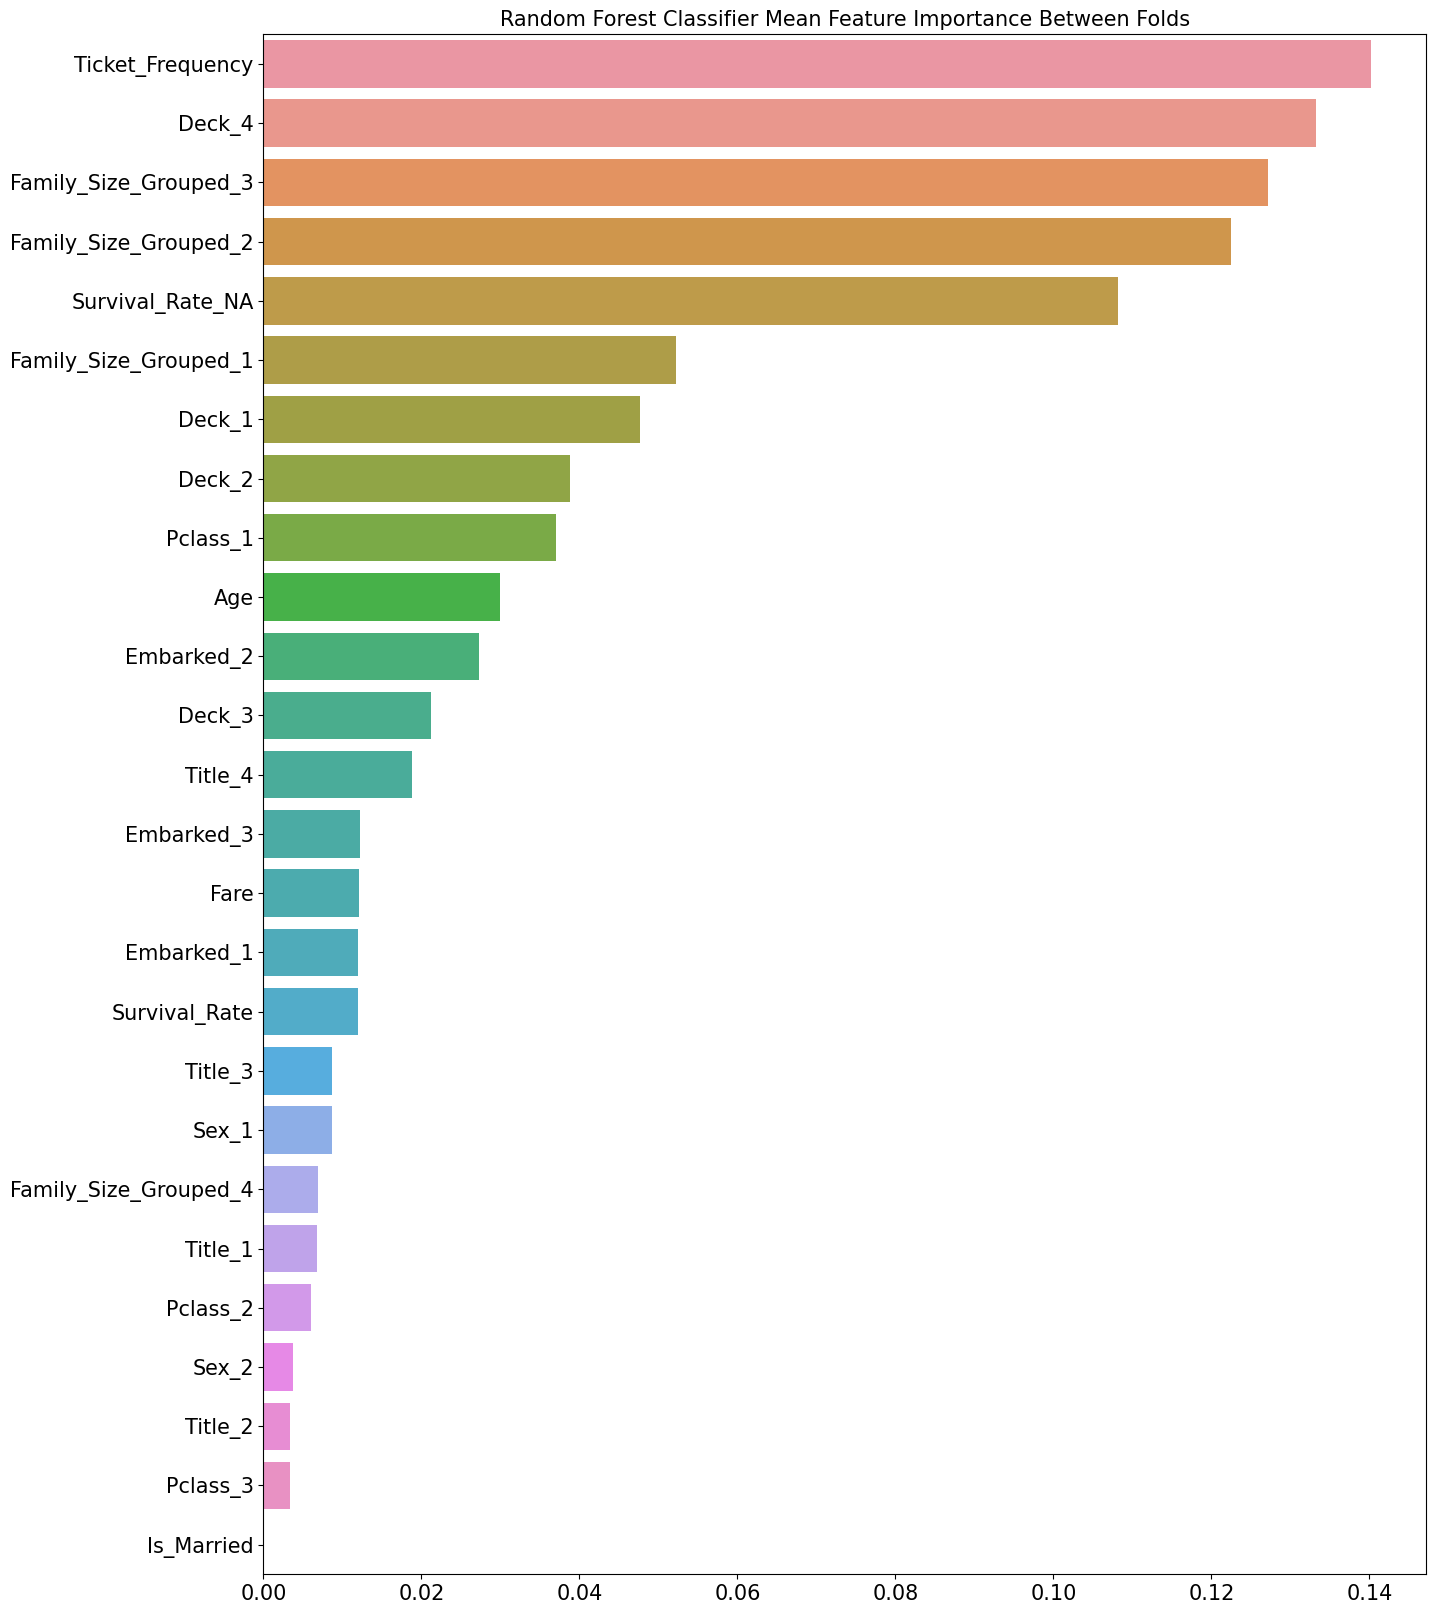

In [49]:
importances['Mean_Importance'] = importances.mean(axis=1)
importances.sort_values(by='Mean_Importance', inplace=True, ascending=False)

plt.figure(figsize=(15, 20))
sns.barplot(x='Mean_Importance', y=importances.index, data=importances)

plt.xlabel('')
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.title('Random Forest Classifier Mean Feature Importance Between Folds', size=15)

plt.show()

### **3.3 ROC Curve**

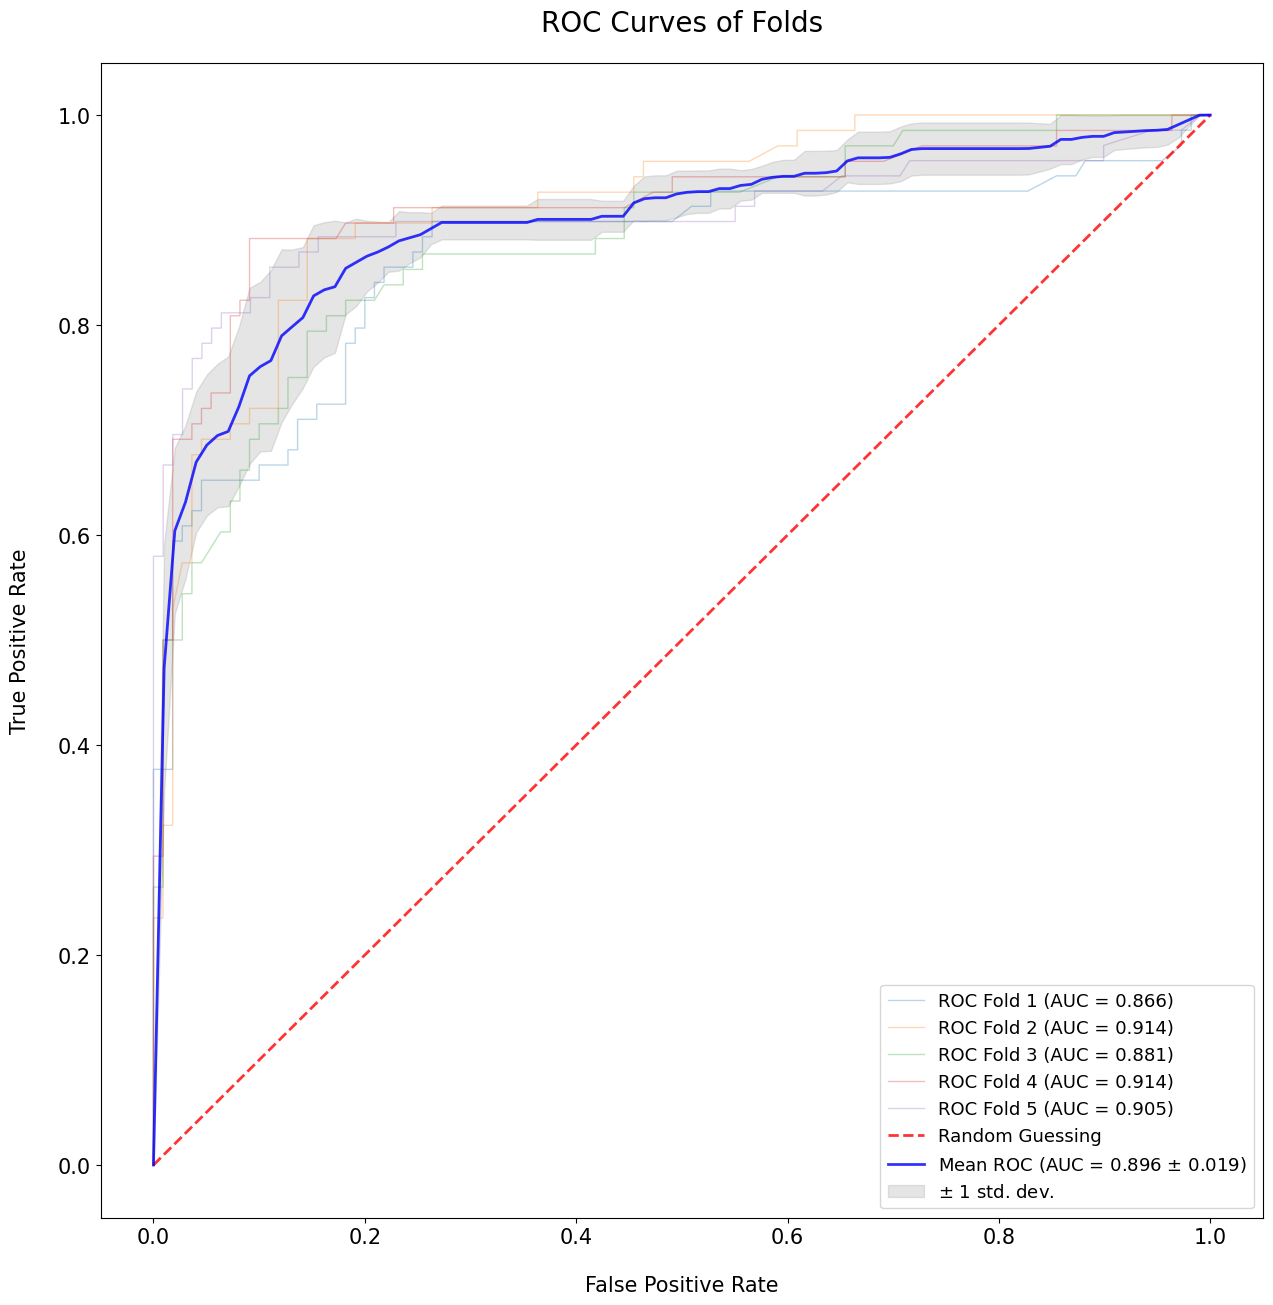

In [50]:
def plot_roc_curve(fprs, tprs):
    
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(15, 15))
    
    # Plotting ROC for each fold and computing AUC scores
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs), 1):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC Fold {} (AUC = {:.3f})'.format(i, roc_auc))
        
    # Plotting ROC for random guessing
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8, label='Random Guessing')
    
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    # Plotting the mean ROC
    ax.plot(mean_fpr, mean_tpr, color='b', label='Mean ROC (AUC = {:.3f} $\pm$ {:.3f})'.format(mean_auc, std_auc), lw=2, alpha=0.8)
    
    # Plotting the standard deviation around the mean ROC Curve
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label='$\pm$ 1 std. dev.')
    
    ax.set_xlabel('False Positive Rate', size=15, labelpad=20)
    ax.set_ylabel('True Positive Rate', size=15, labelpad=20)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])

    ax.set_title('ROC Curves of Folds', size=20, y=1.02)
    ax.legend(loc='lower right', prop={'size': 13})
    
    plt.show()

plot_roc_curve(fprs, tprs)

### **Use the Random Forest Model**

In [51]:
target = train_data["Survived"]
single_best_rf_model.fit(X_train, y_train)
Y_prediction = single_best_rf_model.predict(X_test)

single_best_rf_model.score(X_train, y_train)
acc_random_forest = round(single_best_rf_model.score(X_train, y_train) * 100, 2)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 1100 out of 1100 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s


### **Use the AdaBoost Model**

In [52]:
AdaBoost = AdaBoostClassifier(RandomForestClassifier(n_estimators = 100), algorithm="SAMME", n_estimators=100)
AdaBoost.fit(X_train, y_train)

Ada_prediction = AdaBoost.predict(X_test)

AdaBoost.score(X_train, y_train)
acc_AdaBoost = round(AdaBoost.score(X_train, y_train) * 100, 2)

### **Use the Decision Tree Model**

In [53]:
decision_tree = DecisionTreeClassifier() 
decision_tree.fit(X_train, y_train)

Y_pred = decision_tree.predict(X_test)  

acc_decision_tree = round(decision_tree.score(X_train, y_train) * 100, 2)

In [54]:
GradientBoost = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1,
                                   max_depth=10, max_features=None,
                                   min_samples_leaf=5, min_samples_split=5, random_state =0)
GradientBoost.fit(X_train, y_train)

Ada_prediction = GradientBoost.predict(X_test)

GradientBoost.score(X_train, y_train)
acc_GradientBoost = round(GradientBoost.score(X_train, y_train)* 100, 2)

### **Use the GradientBoosting Model**

In [55]:
import xgboost as xgb
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(X_train, y_train)
xgb_predictions = gbm.predict(X_test)
gbm.score(X_train, y_train)
acc_gbm = round(gbm.score(X_train, y_train) * 100, 2)

### **Use the Logistic Regression Model**

In [56]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

Y_predLog = logreg.predict(X_test)

acc_log = round(logreg.score(X_train, y_train) * 100, 2)

In [57]:
results = pd.DataFrame({
    'Model': ['Random Forest'],
    'Score': [acc_random_forest]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')
result_df.head(9)

results = pd.DataFrame({
    'Model': ['Logistic Regression', 
              'Random Forest', 
              'Decision Tree',
              'AdaBoost',
              'GradientBoost',
             'gbm'],
    'Score': [acc_log, 
              acc_random_forest, acc_decision_tree, acc_AdaBoost , acc_GradientBoost, acc_gbm]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')
result_df.head(9)

,Model
Score,
95.29,Decision Tree
95.29,AdaBoost
95.29,GradientBoost
93.71,gbm
86.20,Logistic Regression
85.63,Random Forest


In [58]:
#output = pd.DataFrame({"PassengerId" : test_data.PassengerId, "Survived": Y})
#output.to_csv('my_submission.csv', index=False)

In [59]:
#output.head()

In [60]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 
              'Random Forest', 
              'Decision Tree',
              'AdaBoost',
              'GradientBoost',
             'gbm'],
    'Score': [acc_log, 
              acc_random_forest, acc_decision_tree, acc_AdaBoost , acc_GradientBoost, acc_gbm]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')
result_df.head(9)

,Model
Score,
95.29,Decision Tree
95.29,AdaBoost
95.29,GradientBoost
93.71,gbm
86.20,Logistic Regression
85.63,Random Forest


### **3.4 Submission**

In [61]:
class_survived = [col for col in probs.columns if col.endswith('Prob_1')]
probs['1'] = probs[class_survived].sum(axis=1) / N
probs['0'] = probs.drop(columns=class_survived).sum(axis=1) / N
probs['pred'] = 0
pos = probs[probs['1'] >= 0.5].index
probs.loc[pos, 'pred'] = 1

y_pred = probs['pred'].astype(int)

submission_d = pd.DataFrame(columns=['PassengerId', 'Survived'])
submission_d['PassengerId'] = test_data['PassengerId']
submission_d['Survived'] = y_pred.values
submission_d.to_csv('my_submissions.csv', header=True, index=False)
submission_d.head(20)

,PassengerId,Survived
891,892,0
892,893,1
893,894,0
894,895,0
895,896,1
896,897,0
897,898,1
898,899,0
899,900,1
900,901,0
